## simialrites 

The goal of this project is to find groups of similar attractions so that the itinerary generator does not display two or more similar attractions on the same day. (e.g. two museums of art)

###Installations and imports

In [1]:
# !pip install -q condacolab
# !pip install simpletransformers
# !pip3 install torch
# import condacolab
# condacolab.install()
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 4.0 MB/s 
     |████████████████████████████████| 4.4 MB 55.7 MB/s 
     |████████████████████████████████| 1.2 MB 74.5 MB/s 
     |████████████████████████████████| 101 kB 14.3 MB/s 
     |████████████████████████████████| 596 kB 89.3 MB/s 
     |████████████████████████████████| 6.6 MB 54.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=cec71e7d76fd01fbd5d3dc0cb07a099243b8207e0a7a4592ba15f423d2e1ba64
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
torch.cuda.is_available()

True

In [2]:
import os
import logging
import warnings
import argparse
import datetime
import numpy as np
import pandas as pd
from itertools import combinations
from collections import Counter
from configparser import ConfigParser
from sentence_transformers import SentenceTransformer, util
pd.set_option('display.max_colwidth', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Extracting the data to a one DataFrame

In [ ]:
# download data from google sheet add a column to indicate the data 
# source of each row

drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/ColabNotebooks/bridgify/duplicates/'
city = 'Mexico_City'
city_csv = 'mexico city'
df_list = []
files = ['_viator', '_tiqets', '_musement', '_google']
for f in files:
  file_path = data_path + city + '/' + city_csv + f + '.csv'
  t_df = pd.read_csv(file_path, encoding='UTF-8')
  t_df['d_source'] = f[1:]
  df_list.append(t_df)

# concat the dataframes
raw_df = pd.concat(df_list).reset_index().drop(columns='index')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
raw_df.shape

NameError: ignored

In [ ]:
raw_df.head()

,name,created,source,address,rating,number_of_reviews,location_point,about,tags,main_photo_url,order_page,curated,is_free,price,hotel_pickup,duration,d_source,external_id
0,Hot Air Balloon Tour - Teotihuacan,2021-10-31 13:30:20.756861,TripAdvisor,NaN,5.0,4,NaN,"The hot air balloon ride in the Teotihuacan Valley allows you to appreciate this amazing setting and its mysterious pyramids. Once at the launch field you can grab a coffee before taking to the air in a magnificent, fully certified and insured British or American built Cameron hot air Balloon piloted by one of our highly experienced, licenced pilots. On landing enjoy a toast with sparkling wine and then a fine buffet breakfast at the Gran Teocalli Restaurant where you can see GoPro photos of the flight (available for purchase). We also give you an attractive certificate to remember the flight by. Available options include round trip transport from Central Mexico City addresses, pyramid tour and a fully private tour PLEASE SELECT YOUR PACKAGE CAREFULLY. AS NOT ALL INCLUDE GUIDED PYRAMID TOUR OR HOTEL PICK-UP. We can arrange: Helicopter transfer, mariachis, birthday and anniversary banners, Marriage proposals, Champagne, flowers, archaeologists and more, Call us once booked in","('Outdoor Activities, Guided Tours, Hidden Gems, Historic Sites, Culture',)",https://media.tacdn.com/media/attractions-splice-spp-154x109/08/42/d4/43.jpg,http://www.viator.com/tours/Mexico-City/HOT-AIR-BALLOON-RIDE-TOUR-FROM-MEXICO-CITY-INCLUDES-BREAKFAST-AND-PYRAMID-GUIDE/d628-129154P1?eap=brand-subbrand-83445&aid=vba83445en,False,False,163.47,True,21600,viator,NaN
1,Mexico City Highlights E-Bike Tour With Foodie Stops,2021-10-31 13:30:21.273671,TripAdvisor,"Laila Hotels, C. Río Lerma 237, Cuauhtémoc, 06500 Ciudad de México, CDMX, Mexico",5.0,2,NaN,"We are an experience focused group, we intend to make the best package of what our city has to offer and we wrap it up and give it via a nice and fun ride with the best vehicles available. You`ll have a comfy ride while discovering exquisite spots around the city, and try out traditional food specially curated for our guests!","('Guided Tours, Walking & Biking, Culture, Street Food',)",https://media.tacdn.com/media/attractions-splice-spp-154x109/07/0a/32/19.jpg,http://www.viator.com/tours/Mexico-City/Full-Package-Mexico-city-electric-bike-tour-With-foddie-stops/d628-116149P1?eap=brand-subbrand-83445&aid=vba83445en,False,False,66.84,False,14400,viator,NaN
2,TEOTIHUACAN with a certified local guide,2021-10-31 13:30:20.979784,TripAdvisor,"Teotihuacán, Pirámide del Sol, 55829 Méx., Mexico",5.0,0,NaN,"Avoid the crowds on this early morning tour of the Teotihuacan pyramids, also known as The City of the Gods. On this tour, an certified native guide takes you around the UNESCO World Heritage site and gives you insight into the majestic site.","('Guided Tours, Historic Sites, Walking & Biking, Hidden Gems',)",https://media.tacdn.com/media/attractions-splice-spp-154x109/0b/2f/de/fc.jpg,http://www.viator.com/tours/Mexico-City/Teotihuacan-with-a-local/d628-108297P3?eap=brand-subbrand-83445&aid=vba83445en,False,False,40.00,False,14400,viator,NaN
3,TEOTIHUACAN BALLOON RIDE (Transportation & breakfast),2021-10-31 13:30:20.671206,TripAdvisor,NaN,5.0,0,NaN,"Get ready for a unique adventure in life!!! This experience is your great opportunity to get to know Teotihuacan from another perspective, out of the ordinary. Fly in a balloon and let the wind take you on an unforgettable journey, witnessing what was the first contact between man and the sky. Capture beautiful panoramic photographs of the beautiful blue sky in the morning in Teotihuacan, in this experience you can admire the magnificent pre-Hispanic city with more influence in Mesoamerica. See from the heights the monumental, harmonious and important architecture of one of the most important wonders of antiquity. The perfect place to fly in a balloon, offers a unique view in the world, with a fascinating past and

In [8]:
# create a csv file of all the inventory suppliers 
raw_df.to_csv("all_mexico.csv")
all_mexico = pd.read_csv("all_mexico.csv")

NameError: ignored

### Data research (continue with all_mexico.csv or with the tagged file of all_mexico_tagged.csv)

In [9]:
all_mexico = pd.read_csv("all_mexico_tagged.csv")

def drop_unamed(df):
  for col in df.columns:
    if 'Unnamed' in col:
      df.drop(columns=[col], inplace=True)

drop_unamed(all_mexico)
all_mexico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               238 non-null    object 
 1   created            238 non-null    object 
 2   source             238 non-null    object 
 3   address            143 non-null    object 
 4   rating             238 non-null    object 
 5   number_of_reviews  238 non-null    int64  
 6   location_point     31 non-null     object 
 7   about              238 non-null    object 
 8   tags               238 non-null    object 
 9   main_photo_url     238 non-null    object 
 10  order_page         238 non-null    object 
 11  curated            238 non-null    bool   
 12  is_free            238 non-null    bool   
 13  price              238 non-null    float64
 14  hotel_pickup       238 non-null    bool   
 15  duration           238 non-null    object 
 16  d_source           238 non

In [10]:
# dropping rows which are exactly the same
# I exclude 'address' from 'drop_duplicates' because in many rows the address is inaccurate or missing so the duplicates will be expressed especially according to 'name' and 'about'

shape_before = all_mexico.shape
all_mexico_reduced = all_mexico.drop_duplicates(subset=["name", "about"])
print(f"Shape befor dropping duplicates: {shape_before}\nshape after dropping duplicates: {all_mexico_reduced.shape}")

Shape befor dropping duplicates: (238, 20)
shape after dropping duplicates: (238, 20)


In [11]:
# change 'unavailable' to nan
text_cols = ["about", "name", "address"]

def unavailable_to_nan(df, cols):
  for col in text_cols:
    df[col] = df[col].apply(lambda x: np.nan if x== 'unavailable' else x)
  

unavailable_to_nan(all_mexico_reduced, text_cols)

In [ ]:
# checking the Nans in the relevant text columns (only in Colab)
chosen_cols = ["about", "name", "address", "external_id"]
sources = all_mexico_reduced["d_source"].unique()
for s in sources:
  print("source:", s)
  print("length:", len(all_mexico_reduced[all_mexico_reduced["d_source"] == s]))
  display(all_mexico_reduced[all_mexico_reduced["d_source"] == s].isna().sum()[chosen_cols])
  print("\n")

source: viator
length: 211


about            0
name             0
address         95
external_id    211
dtype: int64



source: tiqets
length: 7


about          0
name           0
address        0
external_id    0
dtype: int64



source: musement
length: 20


about          0
name           0
address        0
external_id    0
dtype: int64

No external_id in 'google' and 'viator'. Can not use this columns for finding duplicates!

95 'address' are empty in viator<br>
415 'about' are empty in 'google'

In [12]:
# very important to reset the index of the preprocess data!! the original index will be under the column 'index'

all_mexico_reduced = all_mexico_reduced.dropna(subset=text_cols).reset_index()
# if 'Unnamed: 0' in all_mexico_reduced.columns:
#   all_mexico_reduced.drop(columns='Unnamed: 0', inplace=True)
print(f"shape after drop NAN: {all_mexico_reduced.shape}")
all_mexico_reduced.head()

shape after drop NAN: (143, 21)


,index,name,created,source,address,rating,number_of_reviews,location_point,about,tags,...,order_page,curated,is_free,price,hotel_pickup,duration,d_source,external_id,data_source,prediction
0,1,Mexico City Highlights E-Bike Tour With Foodie Stops,2021-10-31 13:30:21.273671,TripAdvisor,"Laila Hotels, C. Río Lerma 237, Cuauhtémoc, 06500 Ciudad de México, CDMX, Mexico",5.0,2,NaN,"We are an experience focused group, we intend to make the best package of what our city has to offer and we wrap it up and give it via a nice and fun ride with the best vehicles available. You`ll have a comfy ride while discovering exquisite spots around the city, and try out traditional food specially curated for our guests!","('Guided Tours, Walking & Biking, Culture, Street Food',)",...,http://www.viator.com/tours/Mexico-City/Full-Package-Mexico-city-electric-bike-tour-With-foddie-stops/d628-116149P1?eap=brand-subbrand-83445&aid=vba83445en,False,False,66.84,False,14400,viator,NaN,NaN,"['Culinary Experiences', 'Nature', 'Outdoor Activities', 'Walking & Biking']"
1,2,TEOTIHUACAN with a certified local guide,2021-10-31 13:30:20.979784,TripAdvisor,"Teotihuacán, Pirámide del Sol, 55829 Méx., Mexico",5.0,0,NaN,"Avoid the crowds on this early morning tour of the Teotihuacan pyramids, also known as The City of the Gods. On this tour, an certified native guide takes you around the UNESCO World Heritage site and gives you insight into the majestic site.","('Guided Tours, Historic Sites, Walking & Biking, Hidden Gems',)",...,http://www.viator.com/tours/Mexico-City/Teotihuacan-with-a-local/d628-108297P3?eap=brand-subbrand-83445&aid=vba83445en,False,False,40.00,False,14400,viator,NaN,NaN,"['Architecture', 'Guided Tours', 'Historic Sites']"
2,4,Foodie Lovers And Trendy CDMX E-bike Tour,2021-10-31 13:30:20.982221,TripAdvisor,"Laila Hotels, C. Río Lerma 237, Cuauhtémoc, 06500 Ciudad de México, CDMX, Mexico",5.0,1,NaN,Discover the Flavors and traditional Street Food of our city while riding trough the Hottest/Trendy Neighborhoods. You`ll try some of the best bites in town cooked by humble hands. *Vegetarian options always available.,"('Guided Tours, Walking & Biking, Street Food',)",...,http://www.viator.com/tours/Mexico-City/Foodie-Lovers-And-Trendy-CDMX-E-bike-Tour/d628-116149P2?eap=brand-subbrand-83445&aid=vba83445en,False,False,66.84,False,14400,viator,NaN,NaN,"['Culinary Experiences', 'Nature', 'Outdoor Activities', 'Walking & Biking']"
3,6,Frida Kahlo Tour with Admission Tickets,2021-10-31 13:30:24.792321,TripAdvisor,"Ignacio Allende 212, Del Carmen, Coyoacán, 04100 Ciudad de México, CDMX, Mexico",4.0,2,NaN,"Highlights: Experience the life and love of Frida and Diego Casa Azul Led by an expert in art What to expect: Frida Kahlo and Diego Rivera helped to define Mexican modernism while engaged in a tumultuous romance. On this Frida Kahlo Tour well get a glimpse into the life of Mexican artists. Our visit will take us to the Frida Kahlo Museum, or Casa Azul, her former abode and where many of her self-portraits were created. We will get a sense of how she once lived and worked. Well engage directly with her history as we surround ourselves by her artwork, her clothing, her photos, and even the prosthetics, and corsets she wore as a result of childhood polio and a horrifying train accident in 1925.","('Walking & Biking, Guided Tours, Architecture, Art, Hidden Gems',)",...,http://www.viator.com/tours/Mexico-City/Frida-Kahlo-Tour/d628-125512P15?eap=brand-subbrand-83445&aid=vba83445en,False,False,65.00,False,109800,viator,NaN,NaN,"['Art', 'Guided Tours', 'Museums']"
4,7,Moctezuma and the Zocalo: The Aztec Empire and its fall,2021-10-31 13:30:22.240036,TripAdvisor,"Zócalo, Plaza de la Constitución, Centro Histórico de la Cdad. de México, Centro, Ciudad de México, CDMX, Mexico",1.0,0,NaN,"Discover the history of the emblematic Zocalo de Mxico, by the hand and voice of a Mexica, who will take you on a tour through the history and origins of the Zocalo and Moctezuma, which

In [13]:
all_mexico_reduced.index

RangeIndex(start=0, stop=143, step=1)

In [14]:
# the original index remains under the column "index"
all_mexico_reduced.columns

Index(['index', 'name', 'created', 'source', 'address', 'rating',
       'number_of_reviews', 'location_point', 'about', 'tags',
       'main_photo_url', 'order_page', 'curated', 'is_free', 'price',
       'hotel_pickup', 'duration', 'd_source', 'external_id', 'data_source',
       'prediction'],
      dtype='object')

It's imortant to remember that the index in the preprocessed data is different from the index in the original data

###Model functions

In [ ]:
# def model_similarity(text_df,col):
#   """
#   return ordered similarity df, according to *one* column, with the columns: index, ind1, ind2, score
#   """
#   model = SentenceTransformer('all-MiniLM-L6-v2')

#   # Single list of sentences
#   sentences = text_df[col].values

#   #Compute embeddings
#   embeddings = model.encode(sentences, convert_to_tensor=True) # each text transforms to a vetor
#   embeddings_df = pd.DataFrame(embeddings) # all vectors dataframe
#   #embeddings_df.set_index(text_df["index"], drop=True, inplace=True)

#   #Compute cosine-similarities for each sentence with each other sentence
#   cosine_scores = util.cos_sim(embeddings, embeddings)

#   #Find the pairs with the highest cosine similarity scores
#   pairs = []
#   for i in range(len(cosine_scores)-1):
#       for j in range(i+1, len(cosine_scores)):
#           pairs.append({'index': [i, j], 'score': cosine_scores[i][j]})

#   #Sort scores in decreasing order
#   pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)

#   # transform to DataFrame and add split the pairs to two colums: 'ind1', 'ind2'
#   pairs_df = pd.DataFrame(pairs)

#   pairs_df["ind1"] = pairs_df["index"].apply(lambda x: x[0]).values
#   pairs_df["ind2"] = pairs_df["index"].apply(lambda x: x[1]).values
#   #pairs_df = pairs_df[pairs_df["score"] > threshold]
#   return pairs_df, embeddings_df

In [15]:
def model_embedding(text_df,col):
  """
  return the embeddings (as torch) of all the text column
  """
  model = SentenceTransformer('all-MiniLM-L6-v2')

  # Single list of sentences
  sentences = text_df[col].values

  #Compute embeddings
  embeddings = model.encode(sentences, convert_to_tensor=True) # each text transforms to a vetor
  return embeddings


def pairs_df_model(embeddings):
  """
  receive embeddings as dataframe.
  Return a DataFrame of computed cosine-similarities for each embedded vector with each other embedded vector.
  """
  cosine_scores = util.cos_sim(embeddings, embeddings)

  #Find the pairs with the highest cosine similarity scores
  pairs = []
  for i in range(len(cosine_scores)-1):
      for j in range(i+1, len(cosine_scores)):
          pairs.append({'index': [i, j], 'score': cosine_scores[i][j]})

  #Sort scores in decreasing order
  pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)

  # transform to DataFrame and add split the pairs to two colums: 'ind1', 'ind2'
  pairs_df = pd.DataFrame(pairs)

  pairs_df["ind1"] = pairs_df["index"].apply(lambda x: x[0]).values
  pairs_df["ind2"] = pairs_df["index"].apply(lambda x: x[1]).values
  #pairs_df = pairs_df[pairs_df["score"] > threshold]
  return pairs_df

# creating df of embeddings for the "about" column
#embeddings = model_embedding(all_mexico_reduced, "about")
#pairs_df = pairs_df_model(embeddings)

In [16]:
# in order to concat the seconderies similarities ('name', 'address') to the main similarity ('about'), there is a need to rename the columns and to drop the index

def df_for_model(df, text_col, name_score):
  """
  The function receives dataframe and a text column (not 'about') according to which the similarity will be calculated 
  and retreives a similarity df with the columns: name_score, "ind1", "ind2"
  """
  embedding = model_embedding(df, text_col)
  df_similarity = pairs_df_model(embedding)
  df_similarity.rename(columns={"score": name_score}, inplace=True)
  return df_similarity.drop(columns=["index"])

name_similarity = df_for_model(all_mexico_reduced, "name", "name_score")
address_similarity = df_for_model(all_mexico_reduced, "address", "address_score")

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
name_similarity

,name_score,ind1,ind2
0,tensor(0.9926),120,134
1,tensor(0.9542),132,135
2,tensor(0.9488),19,21
3,tensor(0.9462),131,140
4,tensor(0.9431),30,141
...,...,...,...
10148,tensor(-0.0629),11,25
10149,tensor(-0.0644),25,43
10150,tensor(-0.0661),25,67
10151,tensor(-0.0671),13,25


In [ ]:
address_similarity

,address_score,ind1,ind2
0,tensor(1.0000),36,66
1,tensor(1.0000),36,93
2,tensor(1.0000),36,102
3,tensor(1.0000),66,93
4,tensor(1.0000),66,102
...,...,...,...
10148,tensor(0.2124),53,116
10149,tensor(0.2124),94,116
10150,tensor(0.2092),58,116
10151,tensor(0.1989),83,116


In [ ]:
def merge_df(df1, df2):
  """
  return merged dataframe according to the values in 'ind1' and ind2'
  """
  return pd.merge(df1, df2, on=["ind1", "ind2"], how="inner")

In [ ]:
# Model main similarity according to 'about'
#about_similarity, embeddings = model_similarity(all_mexico_reduced, "about")
embeddings_about = model_embedding(all_mexico_reduced, "about")
embeddings = pd.DataFrame(embeddings_about)
about_similarity = pairs_df_model(embeddings_about)


In [ ]:
embeddings

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,"tensor(0.0754, device='cuda:0')","tensor(0.0093, device='cuda:0')","tensor(0.0621, device='cuda:0')","tensor(0.0921, device='cuda:0')","tensor(-0.0648, device='cuda:0')","tensor(0.0356, device='cuda:0')","tensor(0.0301, device='cuda:0')","tensor(-0.0741, device='cuda:0')","tensor(-0.0880, device='cuda:0')","tensor(-0.0419, device='cuda:0')",...,"tensor(0.0398, device='cuda:0')","tensor(-0.0006, device='cuda:0')","tensor(-0.0671, device='cuda:0')","tensor(-0.0059, device='cuda:0')","tensor(0.0668, device='cuda:0')","tensor(-0.0470, device='cuda:0')","tensor(-0.0438, device='cuda:0')","tensor(0.0399, device='cuda:0')","tensor(-0.0564, device='cuda:0')","tensor(-0.0223, device='cuda:0')"
1,"tensor(0.0882, device='cuda:0')","tensor(0.1262, device='cuda:0')","tensor(-0.0118, device='cuda:0')","tensor(0.0313, device='cuda:0')","tensor(-0.0021, device='cuda:0')","tensor(-0.0918, device='cuda:0')","tensor(-0.0287, device='cuda:0')","tensor(-0.0254, device='cuda:0')","tensor(0.0374, device='cuda:0')","tensor(0.0191, device='cuda:0')",...,"tensor(-0.0035, device='cuda:0')","tensor(-0.0703, device='cuda:0')","tensor(-0.0653, device='cuda:0')","tensor(-0.0031, device='cuda:0')","tensor(-0.0256, device='cuda:0')","tensor(-0.0396, device='cuda:0')","tensor(0.1051, device='cuda:0')","tensor(0.0074, device='cuda:0')","tensor(-0.0760, device='cuda:0')","tensor(-0.0514, device='cuda:0')"
2,"tensor(0.0475, device='cuda:0')","tensor(-0.0547, device='cuda:0')","tensor(0.0482, device='cuda:0')","tensor(0.0895, device='cuda:0')","tensor(-0.0649, device='cuda:0')","tensor(0.0165, device='cuda:0')","tensor(-0.0022, device='cuda:0')","tensor(-0.0650, device='cuda:0')","tensor(-0.0999, device='cuda:0')","tensor(-0.0807, device='cuda:0')",...,"tensor(-0.0010, device='cuda:0')","tensor(-0.0051, device='cuda:0')","tensor(-0.0752, device='cuda:0')","tensor(-0.0313, device='cuda:0')","tensor(0.0908, device='cuda:0')","tensor(0.0439, device='cuda:0')","tensor(0.0158, device='cuda:0')","tensor(0.0046, device='cuda:0')","tensor(-0.0816, device='cuda:0')","tensor(-0.0145, device='cuda:0')"
3,"tensor(0.0057, device='cuda:0')","tensor(0.0809, device='cuda:0')","tensor(-0.0743, device='cuda:0')","tensor(0.1106, device='cuda:0')","tensor(0.0728, device='cuda:0')","tensor(0.0370, device='cuda:0')","tensor(0.0372, device='cuda:0')","tensor(0.0492, device='cuda:0')","tensor(-0.0206, device='cuda:0')","tensor(0.0276, device='cuda:0')",...,"tensor(0.0373, device='cuda:0')","tensor(-0.0449, device='cuda:0')","tensor(0.0318, device='cuda:0')","tensor(0.0129, device='cuda:0')","tensor(-0.0270, device='cuda:0')","tensor(0.0560, device='cuda:0')","tensor(-0.0223, device='cuda:0')","tensor(0.0481, device='cuda:0')","tensor(0.0107, device='cuda:0')","tensor(-0.0036, device='cuda:0')"
4,"tensor(-0.0009, device='cuda:0')","tensor(0.1168, device='cuda:0')","tensor(0.0080, device='cuda:0')","tensor(0.0609, device='cuda:0')","tensor(-0.0565, device='cuda:0')","tensor(-0.0657, device='cuda:0')","tensor(0.0031, device='cuda:0')","tensor(0.0145, device='cuda:0')","tensor(-0.0336, device='cuda:0')","tensor(-0.0084, device='cuda:0')",...,"tensor(0.0413, device='cuda:0')","tensor(-0.0095, device='cuda:0')","tensor(-0.0417, device='cuda:0')","tensor(0.0459, device='cuda:0')","tensor(0.0476, device='cuda:0')","tensor(-0.0063, device='cuda:0')","tensor(0.0098, device='cuda:0')","tensor(0.0450, device='cuda:0')","tensor(-0.0334, device='cuda:0')","tensor(0.0291, device='cuda:0')"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,"tensor(0.0528, device='cuda:0')","tensor(0.1053, device='cuda:0')","tensor(0.0155, device='cuda:0')","tensor(0.0781, device='cuda:0')","tensor(0.0079, device='cuda:0')","tensor(-0.0940, device='cuda:0')","tensor(-0.0690, device='cuda:0')","tensor(-0.0248, device='cuda:0')","tensor(0.0095, device='cuda:0')","tensor(-0.0306, device='cuda:0')",...,"tensor(0.0022

In [ ]:
about_similarity[(about_similarity["ind2"] == 1) ]

,index,score,ind1,ind2
8222,"[0, 1]","tensor(0.2796, device='cuda:0')",0,1


**Sentence Transformers embeddings** <br>Instead of only using BOW, we are getting float values and fixed dimensions (1 x **384** in this example). This is because the embeddings are taken from a hidden layer in the transformer model, the dimension is the same as the number of neurons of that hidden layer.

In [ ]:
len(embeddings_about[0])

384

In [ ]:
about_similarity


,index,score,ind1,ind2
0,"[65, 68]","tensor(0.9615, device='cuda:0')",65,68
1,"[128, 136]","tensor(0.9465, device='cuda:0')",128,136
2,"[19, 21]","tensor(0.9409, device='cuda:0')",19,21
3,"[3, 18]","tensor(0.9159, device='cuda:0')",3,18
4,"[30, 141]","tensor(0.8992, device='cuda:0')",30,141
...,...,...,...,...
10148,"[37, 84]","tensor(-0.0400, device='cuda:0')",37,84
10149,"[43, 79]","tensor(-0.0404, device='cuda:0')",43,79
10150,"[2, 40]","tensor(-0.0498, device='cuda:0')",2,40
10151,"[37, 58]","tensor(-0.0542, device='cuda:0')",37,58


### create a square matrix of similarities scores

In [ ]:
def similarity_matrix(similarity_idx_df, reduced_df):
  """
  Return n^2 similarity matrix. Each attarction has a similarity score in relation to each attraction in the data
  """
  similarity_matrix = pd.DataFrame(columns=[i for i in range(reduced_df.shape[0])], index=range(reduced_df.shape[0]))
  for i in range(reduced_df.shape[0]):
    for j in range(i,reduced_df.shape[0]):
      if j == i:
        similarity_matrix.iloc[i][j] = 1
        similarity_matrix.iloc[j][i] = 1
      else:
        similarity_score = similarity_idx_df[(similarity_idx_df["ind1"] == i) & (similarity_idx_df["ind2"] == j)]["score"].values
        similarity_matrix.iloc[i][j] = similarity_score
        similarity_matrix.iloc[j][i] = similarity_score
  return similarity_matrix

In [ ]:
about_similarity_matrix = similarity_matrix(about_similarity,all_mexico_reduced)
about_similarity_matrix

,0,1,2,3,4,5,6,7,8,9,...,133,134,135,136,137,138,139,140,141,142
0,1,"[tensor(0.2796, device='cuda:0')]","[tensor(0.6061, device='cuda:0')]","[tensor(0.1901, device='cuda:0')]","[tensor(0.1989, device='cuda:0')]","[tensor(0.4348, device='cuda:0')]","[tensor(0.4700, device='cuda:0')]","[tensor(0.4181, device='cuda:0')]","[tensor(0.4136, device='cuda:0')]","[tensor(0.5379, device='cuda:0')]",...,"[tensor(0.4106, device='cuda:0')]","[tensor(0.1399, device='cuda:0')]","[tensor(0.3657, device='cuda:0')]","[tensor(0.3639, device='cuda:0')]","[tensor(0.4613, device='cuda:0')]","[tensor(0.3184, device='cuda:0')]","[tensor(0.3774, device='cuda:0')]","[tensor(0.2957, device='cuda:0')]","[tensor(0.4049, device='cuda:0')]","[tensor(0.2744, device='cuda:0')]"
1,"[tensor(0.2796, device='cuda:0')]",1,"[tensor(0.0839, device='cuda:0')]","[tensor(0.2172, device='cuda:0')]","[tensor(0.3386, device='cuda:0')]","[tensor(0.4017, device='cuda:0')]","[tensor(0.3909, device='cuda:0')]","[tensor(0.4803, device='cuda:0')]","[tensor(0.4332, device='cuda:0')]","[tensor(0.3423, device='cuda:0')]",...,"[tensor(0.2652, device='cuda:0')]","[tensor(0.2922, device='cuda:0')]","[tensor(0.4993, device='cuda:0')]","[tensor(0.6375, device='cuda:0')]","[tensor(0.4431, device='cuda:0')]","[tensor(0.7084, device='cuda:0')]","[tensor(0.2758, device='cuda:0')]","[tensor(0.7548, device='cuda:0')]","[tensor(0.3023, device='cuda:0')]","[tensor(0.3805, device='cuda:0')]"
2,"[tensor(0.6061, device='cuda:0')]","[tensor(0.0839, device='cuda:0')]",1,"[tensor(0.0336, device='cuda:0')]","[tensor(0.0818, device='cuda:0')]","[tensor(0.2184, device='cuda:0')]","[tensor(0.2379, device='cuda:0')]","[tensor(0.2461, device='cuda:0')]","[tensor(0.2831, device='cuda:0')]","[tensor(0.3589, device='cuda:0')]",...,"[tensor(0.2911, device='cuda:0')]","[tensor(0.0020, device='cuda:0')]","[tensor(0.1718, device='cuda:0')]","[tensor(0.2006, device='cuda:0')]","[tensor(0.3471, device='cuda:0')]","[tensor(0.1634, device='cuda:0')]","[tensor(0.2759, device='cuda:0')]","[tensor(0.0746, device='cuda:0')]","[tensor(0.2749, device='cuda:0')]","[tensor(0.0530, device='cuda:0')]"
3,"[tensor(0.1901, device='cuda:0')]","[tensor(0.2172, device='cuda:0')]","[tensor(0.0336, device='cuda:0')]",1,"[tensor(0.4658, device='cuda:0')]","[tensor(0.5008, device='cuda:0')]","[tensor(0.4423, device='cuda:0')]","[tensor(0.5537, device='cuda:0')]","[tensor(0.3890, device='cuda:0')]","[tensor(0.4160, device='cuda:0')]",...,"[tensor(0.3614, device='cuda:0')]","[tensor(0.4278, device='cuda:0')]","[tensor(0.5151, device='cuda:0')]","[tensor(0.3905, device='cuda:0')]","[tensor(0.3325, device='cuda:0')]","[tensor(0.2933, device='cuda:0')]","[tensor(0.2256, device='cuda:0')]","[tensor(0.3431, device='cuda:0')]","[tensor(0.3877, device='cuda:0')]","[tensor(0.4782, device='cuda:0')]"
4,"[tensor(0.1989, device='cuda:0')]","[tensor(0.3386, device='cuda:0')]","[tensor(0.0818, device='cuda:0')]","[tensor(0.4658, device='cuda:0')]",1,"[tensor(0.4439, device='cuda:0')]","[tensor(0.3562, device='cuda:0')]","[tensor(0.6430, device='cuda:0')]","[tensor(0.5400, device='cuda:0')]","[tensor(0.4070, device='cuda:0')]",...,"[tensor(0.3233, device='cuda:0')]","[tensor(0.4782, device='cuda:0')]","[tensor(0.6334, device='cuda:0')]","[tensor(0.4721, device='cuda:0')]","[tensor(0.4426, device='cuda:0')]","[tensor(0.5034, device='cuda:0')]","[tensor(0.3352, device='cuda:0')]","[tensor(0.4607, device='cuda:0')]","[tensor(0.5376, device='cuda:0')]","[tensor(0.5569, device='cuda:0')]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,"[tensor(0.3184, device='cuda:0')]","[tensor(0.7084, device='cuda:0')]","[tensor(0.1634, device='cuda:0')]","[tensor(0.2933, device='cuda:0')]","[tensor(0.5034, device='cuda:0')]","[tensor(0.5572, device='cuda:0')]","[tensor(0.5333, device='cuda:0')]","[tensor(0.5972, device='cuda:0')]","[tensor(0.5693, device='cuda:0')]","[tensor(0.4465, device='cuda:0')]",...,"[tensor(0.4507, de

If we would like x most similar scores

In [ ]:
x = 10
about_similarity_matrix.iloc[1].sort_values(ascending=False)[1:x+1]

46     [tensor(0.7962, device='cuda:0')]
140    [tensor(0.7548, device='cuda:0')]
138    [tensor(0.7084, device='cuda:0')]
128    [tensor(0.6703, device='cuda:0')]
76     [tensor(0.6490, device='cuda:0')]
136    [tensor(0.6375, device='cuda:0')]
127    [tensor(0.5922, device='cuda:0')]
39     [tensor(0.5840, device='cuda:0')]
132    [tensor(0.5687, device='cuda:0')]
117    [tensor(0.5491, device='cuda:0')]
Name: 1, dtype: object

In [ ]:
def market_place_similarity(similarity_matrix, uuid):
  """
  return the similar attractions of a certain attraction  ### should be changed to a list of uuid insted of index!!
  """
  return similarity_matrix.iloc[uuid][similarity_matrix.iloc[uuid] > 0.78].sort_values(ascending=False).index

In [ ]:
def preprocess_similarity_matrix(similarity_matrix):
  """
  after read to csv, similarity_matrix tensors become type 'str' (insted of float/tensor) and there is a need to turn it back to type 'float'
  """
  for col in similarity_matrix.index:
    similarity_matrix.iloc[col] = similarity_matrix.iloc[col].apply(lambda x: [float(s) for s in re.findall(r'-?\d+\.?\d*', x)][0])

In [ ]:

market_place_similarity(similarity_matrix, 3)

Index(['3', '235', '5', '226'], dtype='object')

In [ ]:
all_mexico_reduced.iloc[[136,1]]

,level_0,index,name,created,source,address,rating,number_of_reviews,location_point,about,...,order_page,curated,is_free,price,hotel_pickup,duration,d_source,external_id,data_source,prediction
136,136,231,"Teotihuacan, Shrine of Guadalupe, and Tlatelolco basic tour",2021-10-31 13:30:16.585303,Musement,"Ángel de la Independencia, EJE 2 PTE, Colonia Cuauhtémoc, Cuauhtémoc, Mexico City, 06600, Mexico",0.0,0,SRID=4326;POINT (-99.1673681 19.4272638),"The tour begins with a visit to Tlatelolco an Aztec archaeological site. Next, you will proceed to know and feel about natural-fiber textiles and obsidian close to Teotihuacan. You'll get to see the sun and moon pyramids, where you can get to the top and admire an impressive view, the place is called ""City of the Gods"" and this archaeological zone is UNESCO world heritage with more than 2,500 years of history.Then you will go to a restaurant called La Catrina, where you’ll try some Mexican dishes (lunch is not included in the price). The tour ends in Mexico’s most important Catholic pilgrimage site, the basilica of Guadalupe dedicated to the Holy Mary of Guadalupe, the traditional Mexican story narrates the Virgin Mary show four times to a native called Juan Diego.",...,https://www.musement.com/us/mexico-city/teotihuacan-shrine-of-guadalupe-and-tlatelolco-basic-tour-239013/?aid=bridgify&cid=bridgify,False,False,54.0,True,28800,musement,901c8faf-bf4f-4870-9bd0-b6beb82111ad,NaN,"['Culture', 'Guided Tours', 'Historic Sites', 'Popular']"
1,1,2,TEOTIHUACAN with a certified local guide,2021-10-31 13:30:20.979784,TripAdvisor,"Teotihuacán, Pirámide del Sol, 55829 Méx., Mexico",5.0,0,NaN,"Avoid the crowds on this early morning tour of the Teotihuacan pyramids, also known as The City of the Gods. On this tour, an certified native guide takes you around the UNESCO World Heritage site and gives you insight into the majestic site.",...,http://www.viator.com/tours/Mexico-City/Teotihuacan-with-a-local/d628-108297P3?eap=brand-subbrand-83445&aid=vba83445en,False,False,40.0,False,14400,viator,NaN,NaN,"['Architecture', 'Guided Tours', 'Historic Sites']"


In [ ]:
# merging all the scores to a one dataframe
similarity_df = merge_df(about_similarity, merge_df(name_similarity, address_similarity))


In [ ]:
# creating a list of the 'scores' columns
scores = [col for col in similarity_df.columns if 'score' in col] 

# creating a new column of 'final_score' that is the average score of all scores
similarity_df["final_score"] = (similarity_df["score"] + similarity_df["name_score"] + similarity_df["address_score"])/len(scores)
similarity_df

,index,score,ind1,ind2,name_score,address_score,final_score
0,"[65, 68]",tensor(0.9615),65,68,tensor(0.6755),tensor(0.6895),tensor(0.7755)
1,"[128, 136]",tensor(0.9465),128,136,tensor(0.9328),tensor(1.0000),tensor(0.9598)
2,"[19, 21]",tensor(0.9409),19,21,tensor(0.9488),tensor(1.0000),tensor(0.9632)
3,"[3, 18]",tensor(0.9159),3,18,tensor(0.8412),tensor(1.0000),tensor(0.9190)
4,"[30, 141]",tensor(0.8992),30,141,tensor(0.9431),tensor(0.5524),tensor(0.7982)
...,...,...,...,...,...,...,...
10148,"[37, 84]",tensor(-0.0400),37,84,tensor(0.2738),tensor(0.4456),tensor(0.2265)
10149,"[43, 79]",tensor(-0.0404),43,79,tensor(0.2489),tensor(0.5243),tensor(0.2443)
10150,"[2, 40]",tensor(-0.0498),2,40,tensor(0.1636),tensor(0.4665),tensor(0.1934)
10151,"[37, 58]",tensor(-0.0542),37,58,tensor(0.2313),tensor(0.4298),tensor(0.2023)


### Creating groups according to 'about' column

#### In this case I've set the threshold to be 0.8, however it depends on the definition of the problem  

In [ ]:
# define similarity threshold dataframe
similarity_df_threshold = similarity_df[similarity_df["score"] > 0.8]

# extracing the attraction which have the same "about"
duplicates_threshold= similarity_df_threshold[similarity_df["score"] > 0.99]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [ ]:
# create similar groups indices 

def groups_idx(similarity_df): # similarity_df = similarity_df_threshold
  """
  return a list of sets of the indices of the similar groups. each index will appear only in one group
  """
  sets_list = list()

  # go over all the index pairs in the dataframe
  for idx in similarity_df["index"].values:
    was_selected = False

    # list that contains all the groups sets
    first_match = set()

    for group in sets_list:
      # if idx has intersection with one of the groups, add the index to the group
      intersec = set(idx) & group
      if len(intersec) > 0:

        # add the index to the group
        group.update(idx)

        # save in the first group match (and collect if there are more matches)
        first_match.update(group)

        # remove the group (it will be inserted with all the matched items )
        sets_list.remove(group)

        # mark that we have intersection for not adding the idx as different group
        was_selected = True
    # after we iterate over all the groups and found the matches for the idx, insert first_match to the sets_list
    if len(first_match) > 0 :
      sets_list.append(first_match)
        
    if not was_selected:
      sets_list.append(set(idx))
      #print(sets_list)

  return sets_list
  
sets_list = groups_idx(similarity_df_threshold)
sets_list_duplicates = groups_idx(duplicates_threshold)

In [ ]:
# average vector for each group

def avg_vec(embeddings_df,group_idx):
  """
  return a np.array of the average vector of the indices of a certain group. 
  group_idx can be a set or a list.
  """
  return np.array(np.mean(embeddings_df.loc[group_idx], axis=0))
  #return torch.mean(torch.from_numpy(embeddings_df.loc[group_idx].values.astype('complex64')), 0)


In [ ]:
# # itai's function (if groups_idx function would be problematic, tell Itai to fix this one)

# def group_pairs_into_sets(idx_pairs):
#     def does_intersect(idx, set_pair):
#         intersection = False   
#         if list(set(idx) & set_pair):
#             intersection = True
#         return intersection
#     sets =  []
#     for pair in idx_pairs:
#         sets_copy = list(sets)
#         was_selected = False
#         first_match = None
#         for num_set in sets:
#             if does_intersect(pair, num_set):
#                 if was_selected:
#                     first_match = set.union(first_match, num_set)
#                 else:
#                     num_set = sets_copy.pop(sets_copy.index(num_set))
#                     num_set = set.union(num_set, set(pair))
#                     sets_copy.append(num_set)
#                     num_set.union(set(pair))
#                     was_selected = True
#                     first_match = num_set
#         if not was_selected:
#             sets_copy.append(set(pair))
#         sets = list(sets_copy)
#     return sets

# group_pairs_into_sets(similarity_df_threshold["index"].values)

In [ ]:
# if not usefull should be dropped! consums relatively long time
def score_avg(idx_list, pairs_df, score_col):
  """
  return the avg similarity score of all indices combinations in the group
  """
  # list for all combinations scores
  score_list = list()
  
  # all possible combinations from idx_list
  for idx in combinations(idx_list, 2):
    idx = sorted(list(idx))
    if idx in list(pairs_df["index"].values):
      # calculating the average score of the group
      score = pairs_df[score_col][(pairs_df["ind1"] == idx[0]) & (pairs_df["ind2"] == idx[1])].values
      score_list.append(score)
  tensor_avg = (sum(score_list) / len(score_list))[0]
  return tensor_avg.item()


In [ ]:
 
def groups_df(similarity_df_threshold, df): # df = all_mexico_reduced
  """
  The function receives a similarity df and the city df and return the rows above the threshold from the dataframe
  """

  # add 'group' column to the above threshold indices and order the dataframe by group
  display_columns = ['name', 'address', 'location_point', 'about', 'tags','prediction', 'price', 'duration', 'source', 'external_id']
  scores = ["score", "name_score", "address_score"]

  # extract the indices
  above_threshold_idx = list(set(np.array([idx for idx in similarity_df_threshold["index"]]).ravel()))
  
  # extract the relevant rows from the dataframe
  df_above_threshold = df.loc[above_threshold_idx][display_columns]
  
  # add 'group' column
  df_above_threshold['about_avg_score'] = 0
  df_above_threshold["name_avg_score"] = 0
  df_above_threshold["address_avg_score"] = 0
  df_above_threshold["final_avg_score"] = 0
  df_above_threshold['group'] = 0
  
  
  # divide the indices to groups according to similarity
  sets_list = groups_idx(similarity_df_threshold)
  
  # update the group columns according to the groups
  for i, group in enumerate(sets_list):
    df_above_threshold['group'].loc[list(group)] = i
    df_above_threshold['about_avg_score'].loc[list(group)] = score_avg(list(group), similarity_df_threshold, "score")
    df_above_threshold['name_avg_score'].loc[list(group)] = score_avg(list(group), similarity_df_threshold, "name_score")
    df_above_threshold['address_avg_score'].loc[list(group)] = score_avg(list(group), similarity_df_threshold, "address_score")
    df_above_threshold["final_avg_score"].loc[list(group)] = score_avg(list(group), similarity_df_threshold, "final_score")

  # order the dataframe by 'group'
  df_above_threshold = df_above_threshold.sort_values(by='group')

  # change the order of the columns so that 'group' will be first
  cols = df_above_threshold.columns.to_list()
  cols = cols[-1:] + cols[:-1]
  df_above_threshold = df_above_threshold[cols]
  return df_above_threshold

similarity_df_groups = groups_df(similarity_df_threshold, all_mexico_reduced)
similarity_df_groups.to_csv("similarity_groups_mexico.csv")

# part of the duplictes are attraction that have ~1 'about' similarity. later on in the code more attraction will be added to the duplicates df
duplicates_df_groups = groups_df(duplicates_threshold, all_mexico_reduced)
duplicates_df_groups

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,group,name,address,location_point,about,tags,prediction,price,duration,source,external_id,about_avg_score,name_avg_score,address_avg_score,final_avg_score


Checking if 'location_point' can use for finding duplicates

In [ ]:
# The dataframe according to 'about' similarity > 0.8
similarity_df_groups #.drop(index=duplicates_df_groups.index)

,group,name,address,location_point,about,tags,prediction,price,duration,source,external_id,about_avg_score,name_avg_score,address_avg_score,final_avg_score
128,0,"Teotihuacan, Shrine of Guadalupe, and Tlatelolco all-inclusive tour","Ángel de la Independencia, EJE 2 PTE, Colonia Cuauhtémoc, Cuauhtémoc, Mexico City, 06600, Mexico",SRID=4326;POINT (-99.1673681 19.4272638),"Your tour begins with a visit to the Aztec archaeological site of Tlatelolco. Next, you will proceed to know and feel about natural-fiber textiles and obsidian close to Teotihuacan. You'll get to see the sun and moon pyramids, where you can get to the top and admire a unique view. The place is called ""City of the Gods"" and this archaeological zone is UNESCO world heritage.The trip continues to ""La Catrina"" restaurant, where you'll have the opportunity to try an authentic Mexican lunch (included in the price). The tour ends with a visit to the Basilica of Guadalupe, Mexico's most important Catholic pilgrimage site. The church is dedicated to the Holy Mary of Guadalupe.","Historic Sites, Culture, Popular","['Culture', 'Guided Tours', 'Historic Sites', 'Popular']",67.00,28800,Musement,16d1cd4c-a3af-4ebd-8a23-2811734c4fd8,0.946509,0.932808,1.000000,0.959772
136,0,"Teotihuacan, Shrine of Guadalupe, and Tlatelolco basic tour","Ángel de la Independencia, EJE 2 PTE, Colonia Cuauhtémoc, Cuauhtémoc, Mexico City, 06600, Mexico",SRID=4326;POINT (-99.1673681 19.4272638),"The tour begins with a visit to Tlatelolco an Aztec archaeological site. Next, you will proceed to know and feel about natural-fiber textiles and obsidian close to Teotihuacan. You'll get to see the sun and moon pyramids, where you can get to the top and admire an impressive view, the place is called ""City of the Gods"" and this archaeological zone is UNESCO world heritage with more than 2,500 years of history.Then you will go to a restaurant called La Catrina, where you’ll try some Mexican dishes (lunch is not included in the price). The tour ends in Mexico’s most important Catholic pilgrimage site, the basilica of Guadalupe dedicated to the Holy Mary of Guadalupe, the traditional Mexican story narrates the Virgin Mary show four times to a native called Juan Diego.","Guided Tours, Historic Sites, Culture, Popular","['Culture', 'Guided Tours', 'Historic Sites', 'Popular']",54.00,28800,Musement,901c8faf-bf4f-4870-9bd0-b6beb82111ad,0.946509,0.932808,1.000000,0.959772
19,1,Coyoacán tour and Frida Kahlo Museum with Admission Tickets,"Parque Centenario, Coyoacán, 04000 Ciudad de México, CDMX, Mexico",NaN,"This tour focuses on the most bohemian side of Mexico City. Coyoacan is one of the kinds of places which seem immune to the passing of time. Since the Spanish conquistador Hernn Corts arrived here back in the 16th century, up until today, it has been home to some of the most interesting characters in Mexican history. We will explore its plazas and cobble-stoned streets built in Colonial style, and admire the scenery amongst studios dedicated to dance, pottery, photography or art, and gorgeous 16th century churches like the church of St. John The Baptist, a symbol of the beautiful Novohispanic Baroque style. We will enjoy the tastes of Mexico in Coyoacans Market, one of its most important icons, try delicious coffee at El Jarocho Cafe. At the end we will get the most famous house in Mexico, Casa Azul, where Frida spent many years. Our guide will give you the tickets so you can explore the museum by yourself","('Walking & Biking, Guided Tours, Art, Historic Sites, Culture',)","['Architecture', 'Culture', 'Guided Tours', 'Historic Sites']",84.32,7200,TripAdvisor,NaN,0.940914,0.948786,1.000000,0.963233
21,1,Private Coyoacan and Frida Kahlo Guided Museum Tour with Admission Tickets,"Parque Centenario, Coyoacán, 04000 Ciudad de México, CDMX, Mexico",NaN,"This tour focuses on the most bohemian side of Mexico City and the life of Frida Kahlo and Diego Riviera. Coyoacan is one of the kinds of places which seem immu

I think it's better to relay on the 'about' column rather than relaying on 'name' or 'address' columns too, because in the group below for example it's the same store just in a different location and therefore under a different name, however, the descriptiopn remain the same.

In [ ]:
similarity_df_groups.shape

(46, 15)

In [ ]:
similarity_df_groups[similarity_df_groups["group"]==2]

,group,name,address,location_point,about,tags,prediction,price,duration,source,external_id,about_avg_score,name_avg_score,address_avg_score,final_avg_score
129,2,Mexico City exploration game and tour in Chimalistac,"Monumento Alvaro Obregón, Calle de la Paz, Colonia Guadalupe Chimalistac, Álvaro Obregón, Mexico City, 01070, Mexico",SRID=4326;POINT (-99.186001 19.347149),"Get a break from all the chaos in the city and a breath of fresh air at the magical colonial suburb of Chimalistac. Play a city game where you follow clues on your smartphone and discover the colorful gardens, iconic landmarks and beautiful hidden alleys in Chimalistac.Each clue will lead you from one place to another by providing you with exact directions so you won't need a map, GPS, or guide. As you solve the problem and guess the answer, the secret story of that place is unlocked.Storyline:You are Jose Maria Velasco, one of the most talented landscape artists in Mexico, no doubt about it! As a prospective teacher at one of the most prestigious school of arts in the country, San Carlos Academy, you are now in search of the 'perfect frame' for your next painting: something peaceful, spiritual… special. You’ve been told you can find that kind of 'special' at the mystical land of Chimalistac, where beautiful hidden colonial treasures await to be found.","Historic sites, Guided Tours, Architecture, Popular, Culture, Guided tours","['Architecture', 'Culture', 'Guided Tours', 'Historic Sites', 'Popular']",12.00,6000,Musement,1eb212a0-252f-46c4-86a8-32f0f03697d3,0.892207,0.787569,0.739432,0.806402
8,2,Private City Exploration Game: the Hidden Gems of Mexico City,"San Luis Potosí, Chimalistac, Álvaro Obregón, 01070 Ciudad de México, CDMX, Mexico",NaN,"Get a break from all the chaos in the city and a breath of fresh air at the magical colonial suburb of Chimalistac. A place full of colorful gardens, iconic landmarks, and beautiful hidden alleys perfect for your next Instagram post! Play as the famous landscape artist Jose Maria Velasco on his search for the perfect frame for his next painting, all while discovering amazing facts about this fantastic location. Are you ready for an adventure? Escape from your typical crowded touristic attractions at Mexico City into a more peaceful and personal experience. Find beautiful hidden colonial landmarks, full of history and charm. Spot little-known places for your next great photo or Instagram post. Each clue will lead you from one place to another by providing you with exact directions so you won't need a map, GPS, or guide. As you answer the questions, solve the challenge, or guess the answer, the secret story of each place is unlocked.","('Guided Tours, Architecture, Walking & Biking, Historic Sites',)","['Architecture', 'Culture', 'Guided Tours', 'Historic Sites', 'Popular']",5.87,144000,TripAdvisor,NaN,0.892207,0.787569,0.739432,0.806402


In [ ]:
all_mexico_reduced["source"].unique()

array(['TripAdvisor', 'Tiqets', 'Musement'], dtype=object)

#### Duplicates

In [ ]:

def duplicates(similarity_groups, duplicates_df_groups):

  # remove the duplicates from the similarity_group dataframe
  similarity_groups_no_duplicates = similarity_groups.drop(index=duplicates_df_groups.index)

  # starting an empty DataFrame for the duplicates
  duplicates_df = pd.DataFrame()

  # transfrom "duration" == np.nan to zero for it to be count in "value_counts()"
  #similarity_groups["duration"] = similarity_groups["duration"].fillna(0)

  # for each group from the similarity DataFrame
  # The below loop ignores attractions with "duraion" == NAN and therefore I needed to drop the duplicates 
  # from the similarities (most of them has "duration" = NAN) and to concate it again after the loop
  for group in similarity_groups_no_duplicates["group"].unique():

    # extracting the rows of a certain group
    similar_group = similarity_groups_no_duplicates[similarity_groups_no_duplicates["group"] == group]

    # if group source is exclusively from musemunts or tiqets, the attractions may be similars but can't be duplicates! 
    if similar_group["source"].unique().all() == "Musement" or similar_group["source"].unique().all() == "Tiqets":
      continue
    # extracting the repeated tags
    tags_count = similar_group["prediction"].value_counts()
    repeated_tags = tags_count[tags_count.values >1].index
    
    # if there are repeated tags inside the group
    if len(repeated_tags) != 0:
      for tag in repeated_tags:
        # extract the rows from the group that have the same tag:
        similar_tags_rows = similar_group[similar_group["prediction"] == tag]

        # out of the rows with the same tag, extract the rows with the same duration:
        duration_count = similar_tags_rows["duration"].value_counts()
        repeated_duration = duration_count[duration_count.values >1].index

        # if there are repeated durations in the group
        if len(repeated_duration) != 0:
          for duration in repeated_duration:
            similar_duration_and_tags_rows = similar_tags_rows[similar_tags_rows["duration"] == duration]
            duplicates_df = pd.concat([duplicates_df, similar_duration_and_tags_rows])

  
  duplicates_df = pd.concat([duplicates_df, duplicates_df_groups])
  if duplicates_df.shape == (0,0):
    print("No duplicates were found!")
  else:
    return duplicates_df

duplicates_df = duplicates(similarity_df_groups, duplicates_df_groups)
duplicates_df.to_csv("duplicates_groups_mexico.csv")
duplicates_df

,group,name,address,location_point,about,tags,prediction,price,duration,source,external_id,about_avg_score,name_avg_score,address_avg_score,final_avg_score
71,16,The best of Mexico CDMX walking tour,"Londres 247, Del Carmen, Coyoacán, 04100 Ciudad de México, CDMX, Mexico",NaN,"Together with the professional guide, you will visit the most charming places in the city. You will have a chance to explore the city, while hearing fascinating facts and legends. Mexico City was the second most populated city of the world for many years, after Tokyo? And that it is located on the mountains? And it owns a Frida Kahlo museum? You will be surprised how many stories are hidden in the streets, buildings and corners of Mexico CDMX. Your charming guide will tell you what is special and unique about living in this city. Perfect for those who are visiting the city for the first time and want to get the most of it! * You will be guided by a local charismatic guide * You will hear the stories and legends of the city * You will visit the charming places","('Guided Tours, Walking & Biking, Historic Sites, Culture',)","['Culture', 'Guided Tours', 'Popular', 'Walking & Biking']",461.70,7200,TripAdvisor,NaN,0.831360,0.621831,0.603190,0.514095
57,16,The best of Mixquic walking tour,"Parroquia de San Andrés Apóstol, Plaza Juárez, entre Independencia y Josefa Ortiz de Domínguez Colonia: Pueblo CDMX C.P, San Bartolo, Tláhuac, 13600 San Andrés Mixquic, CDMX, Mexico",NaN,"Together with the professional guide, you will visit the most charming places in the city. You will have a chance to explore the city, while hearing fascinating facts and legends. Did you know the significance of the Day of the Dead (or Da de Muertos) in Mexico? And that it has a unique celebration to experience? You will be surprised how many stories are hidden in the streets, buildings and corners of Mixquic. Your charming guide will tell you what is special and unique about living in this city. Perfect for those who are visiting the city for the first time and want to get the most of it! * You will be guided by a local charismatic guide * You will hear the stories and legends of the city * You will visit the charming places","('Guided Tours, Walking & Biking, Historic Sites, Culture',)","['Culture', 'Guided Tours', 'Popular', 'Walking & Biking']",461.70,7200,TripAdvisor,NaN,0.831360,0.621831,0.603190,0.514095
65,19,Magic Christmas Tour in Aguascalientes,"Plaza de la Patria, 5 de Mayo 105, Zona Centro, 20000 Aguascalientes, Ags., Mexico",NaN,"How is Christmas celebrated at the heart of Mexico? Discover a wide variety of Mexican traditions and customs, which include a wide range of seasonal cuisine. The Christmas special times brings magic to Aguascalientes. Together with the professional local guide, you will visit the most beautifully decorated places. You will feel spellbound with the charming atmosphere in the streets which you can feel only this time of the year! The visit of sights and craft markets are essential in this tour; There you will find all kinds of Christmas decorations, foods, artisan products, and souvenirs.","('Guided Tours, Walking & Biking, Hidden Gems',)","['Culture', 'Guided Tours', 'Popular']",614.36,7200,TripAdvisor,NaN,0.867399,0.713879,0.610376,0.547914
61,19,Magic Christmas Piñata Tour in Acolman,"Monumento a la Piñata, 55870 Acolman, State of Mexico, Mexico",NaN,"How is Christmas celebrated at the heart of Mexico? Have you ever realized how the Piatas are made and where them come from? Discover a wide variety of Mexican traditions and customs, which include a wide range of seasonal cuisine. Why not doing while visiting the enchanting town of Acolman? The Christmas special times brings magic to Acolman. Together with the professional local guide, you will visit the most beautifully decorated places and learn about the Piata history and about its production. You will feel spellbound with the charming atmosphere in the streets of this enchanting town which you ca

In [ ]:
duplicates_df.shape

(22, 15)

In [ ]:
duplicates_df["group"].value_counts()

16    2
19    2
23    2
25    2
0     2
1     2
2     2
3     2
4     2
5     2
6     2
Name: group, dtype: int64

Duplicates data contain 11 groups of duplicates, 2 rows from each group

####Similarity between the different groups

In [ ]:
avg_vec(embeddings, sets_list[1])

In [ ]:
def group_vectors_df(similarity_df_groups):
  """
  creates a DataFrame of group number and it's average vector"
  """
  groups_vectors_df = pd.DataFrame()
  groups_vectors_df["group"] = similarity_df_groups["group"].unique()
  groups_vectors_df.set_index("group", inplace=True)
  groups_vectors_df["avg_vector"] = 0

  avg_vectors_list = list()
  for group in groups_vectors_df.index:
    #extracting the indices of the group
    group_idx = similarity_df_groups[similarity_df_groups["group"] == group].index
    avg_vectors_list.append(avg_vec(embeddings, group_idx))
  groups_vectors_df["avg_vector"] = avg_vectors_list
  return groups_vectors_df

groups_vectors = group_vectors_df(similarity_df_groups)

In [ ]:
def embeddings_for_model(group_vectors_df):
  """
  Retreive vectors dataframe and return the data as a numpy array for the similarity model
  """
  groups_vectors = group_vectors_df["avg_vector"].values
  return np.array(groups_vectors.tolist())


check for similarity scores between the groups

In [ ]:
# Creating dataframe of the similarity between the groups

model_embeddings = embeddings_for_model(groups_vectors)
groups_similarity = pairs_df_model(model_embeddings)
groups_similarity.to_csv("similarity_between_groups.csv")
groups_similarity

,index,score,ind1,ind2
0,"[9, 13]","tensor(0.8289, dtype=torch.float64)",9,13
1,"[3, 6]","tensor(0.7981, dtype=torch.float64)",3,6
2,"[3, 13]","tensor(0.7952, dtype=torch.float64)",3,13
3,"[3, 5]","tensor(0.7886, dtype=torch.float64)",3,5
4,"[5, 13]","tensor(0.7811, dtype=torch.float64)",5,13
...,...,...,...,...
86,"[7, 11]","tensor(0.4267, dtype=torch.float64)",7,11
87,"[10, 11]","tensor(0.4222, dtype=torch.float64)",10,11
88,"[8, 10]","tensor(0.4190, dtype=torch.float64)",8,10
89,"[10, 12]","tensor(0.4113, dtype=torch.float64)",10,12


In [ ]:
groups_similarity[groups_similarity["score"] >0.7]

,index,score,ind1,ind2
0,"[11, 20]","tensor(0.8401, dtype=torch.float64)",11,20
1,"[22, 26]","tensor(0.8289, dtype=torch.float64)",22,26
2,"[14, 17]","tensor(0.7981, dtype=torch.float64)",14,17
3,"[14, 26]","tensor(0.7952, dtype=torch.float64)",14,26
4,"[14, 16]","tensor(0.7886, dtype=torch.float64)",14,16
5,"[16, 26]","tensor(0.7811, dtype=torch.float64)",16,26
6,"[14, 15]","tensor(0.7775, dtype=torch.float64)",14,15
7,"[14, 22]","tensor(0.7771, dtype=torch.float64)",14,22
8,"[15, 26]","tensor(0.7538, dtype=torch.float64)",15,26
9,"[4, 26]","tensor(0.7527, dtype=torch.float64)",4,26


In [ ]:
def data_attributes(df):
  """
  The function receives the dataframe of the groups and display the the number of groups, number of items from each group and the total number of rows
  """
  print("Number of groups in the data:", df["group"].unique())
  print("\n")
  print("Number of rows in the data:", df.shape[0])
  print("\n")
  print("row count in each group:\n")
  print(df.groupby("group")["name"].count())


# display the number of groups, number of items from each group and the total number of rows
data_attributes(similarity_df_groups)

### groups according to final score

In [ ]:
# extracting the rows above the threshold from similarity dataframe
similarity_df_threshold_final = similarity_df[similarity_df["final_score"] > 0.8]

# deviding the indices to groups
sets_list_final = groups_idx(similarity_df_threshold_final)

# extracting the groups rows from the city dataframe
similarity_df_groups_final = groups_df(similarity_df_threshold_final, all_mexico_reduced)

# saving the results to a csv file
similarity_df_groups_final.to_csv("groups_according_final_score.csv")

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

In [ ]:
data_attributes(similarity_df_groups_final)

Number of groups in the data: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


Number of rows in the data: 33


row count in each group:

group
1     2
2     2
3     2
4     2
5     2
6     4
7     2
8     2
9     2
10    3
11    2
12    3
13    3
14    2
Name: name, dtype: int64


In [ ]:
similarity_df_groups_final

NameError: ignored

### groups according to about column and second filtering according to name column

In [ ]:
# extracting the rows above the threshold from similarity dataframe
similarity_df_threshold_about = similarity_df[similarity_df["final_score"] > 0.8]
similarity_df_threshold_about_name = similarity_df_threshold_about[similarity_df_threshold_about["name_score"] > 0.8]

# deviding the indices to groups
sets_list_final = groups_idx(similarity_df_threshold_about_name)

# extracting the groups rows from the city dataframe
similarity_df_groups_about_name = groups_df(similarity_df_threshold_about_name, all_mexico_reduced)

# saving the results to a csv file
similarity_df_groups_about_name.to_csv("groups_according_about_name.csv")

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

In [ ]:
# display the results

data_attributes(similarity_df_groups_about_name)

Number of groups in the data: [1 2 3 4 5 6 7 8 9]


Number of rows in the data: 20


row count in each group:

group
1    2
2    2
3    2
4    3
5    2
6    2
7    2
8    3
9    2
Name: name, dtype: int64


In [ ]:
similarity_df_groups_about_name

In [ ]:
similarity_df_groups.to_csv("similarity_about_80_groups.csv")

### Pycharm

1. In order to run the code from Pycharm, download the relevant files: main.py and pr_config.ini


2. The code in Pycharm receive the path from the configuration. in 'main' function change arg.path to the name of the updated file (raw_df = pd.read_csv(args.path, encoding='UTF-8')) and comment the line: "args = parse_args(logger)"

In [17]:
!pip install numpy
!pip install pandas
!pip install haversine
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import sys
import uuid
import logging
import warnings
import argparse
import datetime
import numpy as np
import pandas as pd
from itertools import combinations
from collections import Counter
from configparser import ConfigParser
from sentence_transformers import SentenceTransformer, util

#only for pycharm
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/huggingface_hub/snapshot_download.py:11: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  FutureWarning,


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Extract all mexico files to one DataFrame

In [ ]:
# download data from google sheet add a column to indicate the data 
# source of each row

drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/ColabNotebooks/bridgify/duplicates/'
city = 'Mexico_City'
city_csv = 'mexico city'
df_list = []
files = ['_viator', '_tiqets', '_musement']
for f in files:
  file_path = data_path + city + '/' + city_csv + f + '.csv'
  t_df = pd.read_csv(file_path, encoding='UTF-8')
  t_df['d_source'] = f[1:]
  df_list.append(t_df)

# concat the dataframes
raw_df = pd.concat(df_list).reset_index().drop(columns='index')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# create a csv file of all the inventory suppliers 
raw_df.to_csv("all_mexico.csv")

###### Adjustments of a new data to the code (changing the name of the columns)

In [ ]:
new_data = pd.read_csv("all_mexico_tagged.csv")
#new_df = new_data.rename(columns={"title":"name", "description": "about", "categories_list": "tags", "inventory_supplier": "source", "geolocation": 'location_point'})
new_df = new_data.rename(columns={"name": "title", "about": "description","tags":"categories_list", "source": "inventory_supplier", "location_point": "geolocation"})

In [ ]:
new_df = pd.read_csv("berlin_with_geolocation.csv")
new_df = new_df.iloc[:300]

In [ ]:
new_df["geolocation"][0]

'POINT (13.397646 52.520135)'

In [ ]:
if "prediction" in new_df.columns:
  new_df.drop(columns="prediction", inplace=True)

In [ ]:
new_df.to_csv("new_data_df.csv")

In [ ]:
new_df["geolocation"].isna().sum()

0

changing the format of the tags and saving the results in new column="prediction"

In [ ]:
new_df.to_csv("new_data_df.csv")

In [ ]:
pd.read_csv("new_data_df.csv").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              307 non-null    object 
 1   uuid                    307 non-null    object 
 2   created_at              307 non-null    object 
 3   last_updated            305 non-null    object 
 4   title                   307 non-null    object 
 5   description             304 non-null    object 
 6   translation_status      1 non-null      object 
 7   native_name             2 non-null      float64
 8   native_about            7 non-null      object 
 9   address                 266 non-null    object 
 10  geolocation             300 non-null    object 
 11  main_photo_url          299 non-null    object 
 12  availability_type       257 non-null    object 
 13  inventory_supplier      300 non-null    object 
 14  duration                300 non-null    ob

####Pycharm code updated

trying finding duplicates with geolocation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import haversine as hs
# create 'lon' and 'lat' columns
new_df["lon_lat"] = new_df["geolocation"].apply(lambda x: [float(s) for s in re.findall(r'-?\d+\.?\d*', x)][-2:])

idx1, idx2 = 1, 2
loc1 = new_df.loc[idx1]["lon_lat"]
loc2 = new_df.loc[idx2]["lon_lat"]
dist_score = hs.haversine(loc1,loc2)

# list of all the duplicates groups

sets_list = list()
for idx in combinations_idx:
if dist_score <= 0.5:
  loc_list.append(loc1, loc2)
else:




    sets_list = list()

    # go over all the index pairs in the dataframe
    for idx in similarity_df["index"].values:
        was_selected = False

        # list that contains all the groups sets
        first_match = set()

        for group in sets_list:
            # if idx has intersection with one of the groups, add the index to the group
            intersec = set(idx) & group
            if len(intersec) > 0:
                # add the index to the group
                group.update(idx)

                # save in the first group match (and collect if there are more matches)
                first_match.update(group)

                # remove the group (it will be inserted with all the matched items )
                sets_list.remove(group)

                # mark that we have intersection for not adding the idx as different group
                was_selected = True
        # after we iterate over all the groups and found the matches for the idx, insert first_match to the sets_list
        if len(first_match) > 0:
            sets_list.append(first_match)

        if not was_selected:
            sets_list.append(set(idx))

    return sets_list

22.682468231045124

similarity new- 21/06/22

In [ ]:
import os
import re
import datetime
import sys
import numpy as np
import pandas as pd
import logging
import argparse
import haversine as hs
from itertools import combinations
from collections import Counter
from configparser import ConfigParser
from sentence_transformers import SentenceTransformer, util

# read config file
config_object = ConfigParser()
config_object.read("pr_config.ini")


def parse_args(logger):
    """
    This function initialize the parser and the input parameters
    """

    my_parser = argparse.ArgumentParser(description=config_object['params']['description'])
    my_parser.add_argument('--path', '-p',
                           required=True,
                           type=str,
                           help="config_object['params']['path_help']")

    my_parser.add_argument('--save', '-s',
                           required=False,
                           type=str, default=None,
                           help=config_object['params']['save_help'])

    args = my_parser.parse_args()
    logger.info('Parsed arguments')
    return args


def val_input(args, logger):
    """
    This function validated that the input file exists and that the output path's folder exists
    """

    if not os.path.isfile(args.path):
        logger.debug('the input file doesn\'t exists')
        return False

    if args.save:
        if '/' in args.save:
            folder = "/".join(args.save.split('/')[:-1])
            if not os.path.exists(folder):
                logger.debug('the output folder doesn\'t exists')
                return False
        else:
            folder = "/".join(args.path.split('/')[:-1])
            args.save = folder + '/' + args.save

    else:
        current_time = datetime.datetime.now()
        save_path = f'processed_data_{current_time.year}-{current_time.month}-{current_time.day}-{current_time.hour}-' \
                    f'{current_time.minute}.xlsx'
        args.save = save_path
        logger.info('the save path was set to default')
    logger.info(f'args={args}')
    logger.info('input was validated')
    return True


def init_logger():
    """
    This function initialize the logger and returns its handle
    """

    log_formatter = logging.Formatter('%(levelname)s-%(asctime)s-FUNC:%(funcName)s-LINE:%(lineno)d-%(message)s')
    logger = logging.getLogger('log')
    logger.setLevel('DEBUG')
    file_handler = logging.FileHandler('pr_log.txt')
    file_handler.setLevel(logging.DEBUG)
    file_handler.setFormatter(log_formatter)
    logger.addHandler(file_handler)

    return logger


def unavailable_to_nan(df, col_list, logger):
    """ change the 'unavailable' to nan, replace nan with empty string for joining the text columns"""

    for col in col_list:
        try:
            df[col] = df[col].apply(lambda x: np.nan if x == 'unavailable' else x)
            df[col] = df[col].fillna("")
        except KeyError as er:
            logger.debug(f'{col} column is missing from the DataFrame!')
            print(er)
            sys.exit(1)


def remove_duplicates_and_nan(df, logger):
    """ Remove rows which are exactly the same """

    logger.info(f"Shape before removing duplicates and Nans: {df.shape}")
    print("Shape before removing duplicates and Nans:", df.shape)
    try:
        # I exclude 'address' from 'drop_duplicates' because in many rows the address is inaccurate or missing so the
        # duplicates will be expressed especially according to 'title' and 'description'
        df.drop_duplicates(subset=['title', 'description', 'address'], inplace=True)
        df.dropna(subset=["text"], inplace=True)
        df.reset_index(inplace=True)

    except KeyError as er:
        logger.debug("One or more columns from the list ['title','description'] are missing from the "
                     "DataFrame!")
        print(er)
        sys.exit(1)

    logger.info(f"Shape after removing duplicates: {df.shape}")
    print("Shape after removing duplicates:", df.shape)
    return df


def tags_format(df):
    """
    Transforming each tag in "categories_list" column to a list
     """
    try:
        return df["categories_list"].apply(
            lambda x: list(set([j.strip().title() for j in re.sub(r'[()\[\'"{}\]]', '', x).strip().split(",")])) if type(
                x) != list else x)
    except Exception as er:
        #log_f.logger.debug('Check "categories_list" column or categories_list format')
        print(er)
        sys.exit(1)

def strip_list(df,col):
  df[col] = df[col].apply(lambda x: [ele for ele in x if ele.strip()])


def model_embedding(text_df, col):
    """
  return the embeddings (as torch) of all the text column
  """
    model = SentenceTransformer('all-MiniLM-L6-v2')

    # Single list of sentences
    sentences = text_df[col].values

    # Compute embeddings
    embeddings = model.encode(sentences, convert_to_tensor=True)  # each text transforms to a vector
    print("model embedding:", type(embeddings))
    return embeddings


def data_preprocess(raw_df, logger):
  """
  return preprocessed dataframe
  """ 
  raw_df = raw_df.rename(
        columns={"name": "title", "about": "description", "tags": "categories_list", "source": "inventory_supplier",
                 "location_point": "geolocation"})
  if 'prediction' not in raw_df.columns:
      raw_df["prediction"] = tags_format(raw_df)
      strip_list(raw_df, "prediction")
      raw_df["prediction"] = raw_df["prediction"].apply(lambda x: str(x))
    
  # 'unavailable' to NAN
  unavailable_to_nan(raw_df, ["title", "description"], logger)

  # Remove rows which are exactly the same
  raw_df["text"] = raw_df["title"] + ' ' + raw_df["description"]
  df = remove_duplicates_and_nan(raw_df, logger)
  logger.info("The data were processed")
  return df


def pairs_df_model(embeddings):
    """
  receive embeddings as dataframe.
  Return a DataFrame of computed cosine-similarities for each embedded vector with each other embedded vector.
  The shape of the DataFrame supposed to be (len(embedding), len(embeddings))
  """
    cosine_scores = util.cos_sim(embeddings, embeddings)

    # Find the pairs with the highest cosine similarity scores
    pairs = []
    for i in range(len(cosine_scores) - 1):
        for j in range(i + 1, len(cosine_scores)):
            pairs.append({'index': [i, j], 'score': cosine_scores[i][j]})

    # Sort scores in decreasing order
    pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)

    # transform to DataFrame and add split the pairs to two colums: 'ind1', 'ind2'
    pairs_df = pd.DataFrame(pairs)

    pairs_df["ind1"] = pairs_df["index"].apply(lambda x: x[0]).values
    pairs_df["ind2"] = pairs_df["index"].apply(lambda x: x[1]).values
    # pairs_df = pairs_df[pairs_df["score"] > threshold]
    return pairs_df


def similarity_matrix(similarity_idx_df, reduced_df):
  """
  Return n^2 similarity matrix. Each attarction has a similarity score in relation to each attraction in the data
  """
  similarity_matrix = pd.DataFrame(columns=[i for i in range(reduced_df.shape[0])], index=range(reduced_df.shape[0]))
  for i in range(reduced_df.shape[0]):
    for j in range(i,reduced_df.shape[0]):
      if j == i:
        similarity_matrix.iloc[i][j] = 1
        similarity_matrix.iloc[j][i] = 1
      else:
        similarity_score = similarity_idx_df[(similarity_idx_df["ind1"] == i) & (similarity_idx_df["ind2"] == j)]["score"].values
        similarity_matrix.iloc[i][j] = similarity_score
        similarity_matrix.iloc[j][i] = similarity_score
  return similarity_matrix



def df_for_model(df, text_col, name_score):
    """
    The function receives dataframe and a text column (not 'description') according to which the similarity will be calculated
    and retrieves a similarity df with the columns: name_score, "ind1", "ind2"
    """
    embedding = model_embedding(df, text_col)
    df_similarity = pairs_df_model(embedding)
    df_similarity.rename(columns={"score": name_score}, inplace=True)
    return df_similarity.drop(columns=["index"])


def merge_df(df1, df2):
    """
    return merged dataframe according to the values in 'ind1' and ind2'
     """
    return pd.merge(df1, df2, on=["ind1", "ind2"], how="inner")


def groups_idx(similarity_df):
    """
    :param similarity_df: receive the similarity df above a certain threshold
    :return: a tuples list of all groups indices (A group consists of the pairs of a particular index and the pairs of
    its couples. There is no overlap of indices between the groups
    """
    sets_list = list()

    # go over all the index pairs in the dataframe
    for idx in similarity_df["index"].values:
        was_selected = False

        # list that contains all the groups sets
        first_match = set()

        for group in sets_list:
            # if idx has intersection with one of the groups, add the index to the group
            intersec = set(idx) & group
            if len(intersec) > 0:
                # add the index to the group
                group.update(idx)

                # save in the first group match (and collect if there are more matches)
                first_match.update(group)

                # remove the group (it will be inserted with all the matched items )
                sets_list.remove(group)

                # mark that we have intersection for not adding the idx as different group
                was_selected = True
        # after we iterate over all the groups and found the matches for the idx, insert first_match to the sets_list
        if len(first_match) > 0:
            sets_list.append(first_match)

        if not was_selected:
            sets_list.append(set(idx))

    return sets_list


def score_avg(idx_list, pairs_df, score_col):
    """
    return the average similarity score of all combinations in the group
    (May consume a lot of time with big data with many combinations)
    """
    # list for all combinations scores
    score_list = list()

    # all possible combinations from idx_list
    for idx in combinations(idx_list, 2):
        idx = sorted(list(idx))
        if idx in list(pairs_df["index"].values):
            # calculating the average score of the group
            score = pairs_df[score_col][(pairs_df["ind1"] == idx[0]) & (pairs_df["ind2"] == idx[1])].values
            score_list.append(score)
    tensor_avg = (sum(score_list) / len(score_list))[0]
    return tensor_avg.item()


def groups_df(similarity_df_threshold, df):  # df = all_mexico_reduced
    """
    The function receives a similarity df and the city df and return the rows above the threshold from the dataframe
    """

    # add 'group' column to the above threshold indices and order the dataframe by group
    display_columns = ['title', 'address', 'geolocation', 'description', 'categories_list', 'prediction', 'price', 'duration',
                       'inventory_supplier', 'external_id']
    scores = ["score", "title_score", "address_score"]

    # extract the indices
    above_threshold_idx = list(set(np.array([idx for idx in similarity_df_threshold["index"]]).ravel()))
    
    # extract the relevant rows from the dataframe
    df_above_threshold = df.loc[above_threshold_idx][display_columns]

    # add 'group' column
    # df_above_threshold['description_avg_score'] = 0

    df_above_threshold['group'] = 0

    # divide the indices to groups according to similarity
    sets_list = groups_idx(similarity_df_threshold)

    # update the group columns according to the groups
    for i, group in enumerate(sets_list):
        df_above_threshold['group'].loc[list(group)] = i
        # df_above_threshold['description_avg_score'].loc[list(group)] = score_avg(list(group), similarity_df_threshold,
        #                                                                    "score")


    # order the dataframe by 'group'
    df_above_threshold = df_above_threshold.sort_values(by='group')

    # change the order of the columns so that 'group' will be first
    cols = df_above_threshold.columns.to_list()
    cols = cols[-1:] + cols[:-1]
    df_above_threshold = df_above_threshold[cols]
    return df_above_threshold


def avg_vec(embeddings_df, group_idx):
    """
    return a np.array of the average vector of the indices of a certain group.
    group_idx can be a set or a list.
    """
    return np.array(np.mean(embeddings_df.loc[group_idx], axis=0))


def group_vectors_df(similarity_df_groups, embeddings):
    """
  creates a DataFrame of group number, and it's average vector
  in order to find similarities between the groups
  """
    groups_vectors_df = pd.DataFrame()
    groups_vectors_df["group"] = similarity_df_groups["group"].unique()
    groups_vectors_df.set_index("group", inplace=True)
    groups_vectors_df["avg_vector"] = 0

    avg_vectors_list = list()
    for group in groups_vectors_df.index:
        # extracting the indices of the group
        group_idx = similarity_df_groups[similarity_df_groups["group"] == group].index
        avg_vectors_list.append(avg_vec(embeddings, group_idx))
    groups_vectors_df["avg_vector"] = avg_vectors_list
    return groups_vectors_df


def embeddings_for_model(group_vectors_df):
    """
    Retrieve vectors dataframe and return the data as a numpy array for the similarity model
    """
    groups_vectors = group_vectors_df["avg_vector"].values
    return np.array(groups_vectors.tolist())


def last_col_first(df):
    """
  changing the order of the columns so the last column will be the first column in the dataframe
  """
    cols = df.columns.to_list()
    cols = cols[-1:] + cols[:-1]
    return df[cols]


def duplicates(similarity_groups, similarity_matrix, logger):
    """
    :param similarity_groups: similarity dataframe
    :param duplicates_df_groups: similarity df of "text" score > 0.99
    :param logger: logger
    :return: duplicates df and creates a "duplicates.csv" file
    """
    duplicate_group = 0


    # starting an empty DataFrame for the duplicates
    duplicates_df = pd.DataFrame()

    # checking for duplicates in every group of similarity
    for group in similarity_groups["group"].unique():

        # extracting the rows of a certain group
        similar_group = similarity_groups[similarity_groups["group"] == group]

        reliable_sources = ["Musement", "Tiqets", "Ticketmaster", "Getyourguide"]
        not_reliable_suppliers = ["GoogleMaps", "Viator"]

        # extracting the repeated tags
        tags_count = similar_group["prediction"].value_counts()

        # list of the repeated tags
        repeated_tags = tags_count[tags_count.values > 1].index

        # if there are repeated tags inside the group
        if len(repeated_tags) != 0:

          for tag in repeated_tags:
            # extract the rows from the group that have the same tag:
            similar_tags_rows = similar_group[similar_group["prediction"] == tag]

            # out of the rows with the same tag, extract the rows with the same duration:
            duration_count = similar_tags_rows["duration"].value_counts()
            repeated_duration = duration_count[duration_count.values > 1].index

            # if there are repeated durations in the group
            if len(repeated_duration) != 0:
                for duration in repeated_duration:
                    similar_duration_and_tags_rows = similar_tags_rows[similar_tags_rows["duration"] == duration]
                    
                    # Find the median
                    median_price = np.median(similar_duration_and_tags_rows["price"])
                    
                    #delete the attractions that are not within 20% of the median
                    median_range = median_price * 0.2
                    median_bottom = median_price - median_range
                    median_top = median_price + median_range
                    idx_to_drop = list()
                    
                    for row in similar_duration_and_tags_rows.index:
                      if not median_bottom <= similar_duration_and_tags_rows.loc[row]["price"] <= median_top:
                        print("bottom:", median_bottom)
                        print("top", median_top)
                        print("price:",  similar_duration_and_tags_rows.loc[row]["price"])
                        idx_to_drop.append(row)
                    similar_duration_and_tags_rows.drop(index=idx_to_drop, inplace=True)
                    # if there are no duplicates after dropping the indices
                    if not similar_duration_and_tags_rows.shape[0] > 1:
                      continue

                    # changing the order of the columns so that the group number will be the first column
                    similar_duration_and_tags_rows = last_col_first(similar_duration_and_tags_rows)

                    # if group source is exclusively from musemunts or tiqets, the attractions may be similars but can't be
                    # duplicates!
                    if len(similar_duration_and_tags_rows["inventory_supplier"].unique()) == 1 and \
                            similar_duration_and_tags_rows["inventory_supplier"].unique()[0]  in reliable_sources:
                        continue
                    else:
                      similar_duration_and_tags_rows["duplicate_group"] = int(duplicate_group)
                      duplicate_group += 1

                      scores_dict = dict()
                      # create a column with every combination within the group and its score
                      idx_combinations = combinations(similar_duration_and_tags_rows.index, 2)
                      for comb in idx_combinations:
                        score = similarity_matrix.loc[comb[0]][comb[1]]
                        scores_dict[str(comb)] = round(score, 2)
                      similar_duration_and_tags_rows["scores"] = [scores_dict for i in range(similar_duration_and_tags_rows.shape[0])]
                      duplicates_df = pd.concat([duplicates_df, similar_duration_and_tags_rows])
                      print("duplicate:")
                      display(duplicates_df)

    
    duplicates_df = last_col_first(duplicates_df)
    duplicates_df = last_col_first(duplicates_df)

    # concat the duplicate of "text" similarity > 0.99 to the duplicates of tags and duration
    #duplicates_df = pd.concat([duplicates_df, duplicates_df_groups])
    duplicates_df.rename(columns={"group": "similarity_group"}, inplace=True)

    # if no duplicates were found
    if duplicates_df.shape[0] == 0:
        print("No duplicates were found!")
        logger.info("No duplicates were found!")
    else:
        duplicates_df.to_csv("duplicates.csv")
        logger.info("Created duplicates.csv file")
        return duplicates_df


def data_attributes(df):
    """
    :param df: The groups dataframe that was extracted from the original data
    :return: print the dataframe information
    """
    print("Number of groups in the data:", df["group"].nunique())
    print("\n")
    print("Number of rows in the data:", df.shape[0])
    print("\n")
    print("row count in each group:\n")
    print(df.groupby("group")["title"].count())



def main(path):
    # config logger
    logger = init_logger()
    logger.info('STARTED RUNNING')

    # # parse args
    # args = parse_args(logger)

    # # validate the input
    # if not val_input(args, logger):
    #     logger.debug('Terminating due to invalid input')
    #     exit()

    # load the data
    
    #raw_df = pd.read_csv(path, encoding='UTF-8')
    raw_df = new_df


    df_reduced = data_preprocess(raw_df, logger)

    # Creating similarity DataFrame according to 'text'
    embeddings_text = model_embedding(df_reduced, "text")
    embeddings = pd.DataFrame(embeddings_text)
    text_similarity = pairs_df_model(embeddings_text)

    # create a square matrix of the similarity scores
    similarity_matrix_text = similarity_matrix(text_similarity, df_reduced)
    similarity_matrix_text.to_csv("similarity_matrix.csv", index=False)

    # merging all the scores to one dataframe
    similarity_df = text_similarity

    # filtering according to 'description' column.
    similarity_df_threshold = similarity_df[similarity_df["score"] > float(config_object['const']['threshold'])]

    # extract the rows above the threshold from the dataframe
    similarity_df_groups = groups_df(similarity_df_threshold, df_reduced)

    # saving the groups dataframe to a csv file
    similarity_df_groups.to_csv("similarities.csv")
    logger.info("Finished created 'similarities.csv' file")

    # print groups dataframe information
    data_attributes(similarity_df_groups)

    #### creating dataframe for the similarity between the groups
    groups_vectors = group_vectors_df(similarity_df_groups, embeddings)

    model_embeddings = embeddings_for_model(groups_vectors)
    groups_similarity = pairs_df_model(model_embeddings)
    groups_similarity.to_csv("similarity_between_groups.csv")
    logger.info("Finished created 'similarity_between_groups.csv' file")

    ### creating a duplicate DataFrame

    # Filtering according to 'text' similarity score > 0.99
    #duplicates_threshold = similarity_df_threshold[similarity_df["score"] > 0.99]

    # extract the rows above the threshold 0.99 from the dataframe
    #duplicates_df_groups = groups_df(duplicates_threshold, df_reduced)

    # transforming tensors to floats (For visuals only)
    for i in range(similarity_matrix_text.shape[0]):
      similarity_matrix_text.iloc[i] = similarity_matrix_text.iloc[i].astype('float')

    duplicates_df = duplicates(similarity_df_groups, similarity_matrix_text, logger)
    # duplicates_df.to_csv("duplicates_groups_mexico.csv")
    return df_reduced

if __name__ == "__main__":
    df_test1 = main("new_data_df.csv")



Shape before removing duplicates and Nans: (238, 23)
Shape after removing duplicates: (238, 24)


/usr/local/lib/python3.7/dist-packages/huggingface_hub/file_download.py:563: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  FutureWarning,


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

model embedding: <class 'torch.Tensor'>


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Number of groups in the data: 14


Number of rows in the data: 125


row count in each group:

group
0      3
1      2
2      3
3      2
4      3
5      3
6      3
7      8
8      4
9      3
10     3
11    17
12    65
13     6
Name: title, dtype: int64
duplicate:


,duplicate_group,group,title,address,geolocation,description,categories_list,prediction,price,duration,inventory_supplier,external_id,scores
105,0,5,Magic Christmas Tour in Tepotzotlan,"Plaza de la Cruz, San Martin, 54605 Tepotzotlá...",NaN,How is Christmas celebrated at the heart of Me...,"('Guided Tours, Walking & Biking, Hidden Gems',)","['Hidden Gems', 'Guided Tours', 'Walking & Bik...",614.36,7200,TripAdvisor,NaN,"{'(105, 114)': 0.81}"
114,0,5,Magic Christmas Tour in CDMX,"Zócalo, Plaza de la Constitución, Centro Histó...",NaN,How is Christmas celebrated at the heart of Me...,"('Guided Tours, Walking & Biking, Hidden Gems',)","['Hidden Gems', 'Guided Tours', 'Walking & Bik...",615.94,7200,TripAdvisor,NaN,"{'(105, 114)': 0.81}"


duplicate:


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,duplicate_group,group,title,address,geolocation,description,categories_list,prediction,price,duration,inventory_supplier,external_id,scores
105,0,5,Magic Christmas Tour in Tepotzotlan,"Plaza de la Cruz, San Martin, 54605 Tepotzotlá...",NaN,How is Christmas celebrated at the heart of Me...,"('Guided Tours, Walking & Biking, Hidden Gems',)","['Hidden Gems', 'Guided Tours', 'Walking & Bik...",614.36,7200,TripAdvisor,NaN,"{'(105, 114)': 0.81}"
114,0,5,Magic Christmas Tour in CDMX,"Zócalo, Plaza de la Constitución, Centro Histó...",NaN,How is Christmas celebrated at the heart of Me...,"('Guided Tours, Walking & Biking, Hidden Gems',)","['Hidden Gems', 'Guided Tours', 'Walking & Bik...",615.94,7200,TripAdvisor,NaN,"{'(105, 114)': 0.81}"
109,1,11,"Shared Tour to Xochimilco, Coyoacan and Museum...",NaN,NaN,After picking you up at your hotel we will go ...,"('Guided Tours, Historic Sites, Culture',)","['Culture', 'Historic Sites', 'Guided Tours']",59.99,21600,TripAdvisor,NaN,"{'(109, 207)': 0.81}"
207,1,11,"Frida Kahlo Museum, Coyoacan, Xochimilco and U...",NaN,NaN,Coyoacan is one of the most well preserved col...,"('Guided Tours, Historic Sites, Culture',)","['Culture', 'Historic Sites', 'Guided Tours']",40.44,21600,TripAdvisor,NaN,"{'(109, 207)': 0.81}"


duplicate:


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,duplicate_group,group,title,address,geolocation,description,categories_list,prediction,price,duration,inventory_supplier,external_id,scores
105,0,5,Magic Christmas Tour in Tepotzotlan,"Plaza de la Cruz, San Martin, 54605 Tepotzotlá...",NaN,How is Christmas celebrated at the heart of Me...,"('Guided Tours, Walking & Biking, Hidden Gems',)","['Hidden Gems', 'Guided Tours', 'Walking & Bik...",614.36,7200,TripAdvisor,NaN,"{'(105, 114)': 0.81}"
114,0,5,Magic Christmas Tour in CDMX,"Zócalo, Plaza de la Constitución, Centro Histó...",NaN,How is Christmas celebrated at the heart of Me...,"('Guided Tours, Walking & Biking, Hidden Gems',)","['Hidden Gems', 'Guided Tours', 'Walking & Bik...",615.94,7200,TripAdvisor,NaN,"{'(105, 114)': 0.81}"
109,1,11,"Shared Tour to Xochimilco, Coyoacan and Museum...",NaN,NaN,After picking you up at your hotel we will go ...,"('Guided Tours, Historic Sites, Culture',)","['Culture', 'Historic Sites', 'Guided Tours']",59.99,21600,TripAdvisor,NaN,"{'(109, 207)': 0.81}"
207,1,11,"Frida Kahlo Museum, Coyoacan, Xochimilco and U...",NaN,NaN,Coyoacan is one of the most well preserved col...,"('Guided Tours, Historic Sites, Culture',)","['Culture', 'Historic Sites', 'Guided Tours']",40.44,21600,TripAdvisor,NaN,"{'(109, 207)': 0.81}"
81,2,11,Xochimilco and Frida Khalo,NaN,NaN,* VISIT one of Diego Rivera's least visited mu...,"('Guided Tours, Historic Sites, Culture',)","['Culture', 'Historic Sites', 'Guided Tours']",110.00,25200,TripAdvisor,NaN,"{'(81, 58)': 0.81}"
58,2,11,"Coyoacan Private Tour, Frida Kahlo Museum and ...",NaN,NaN,We will take you to tour one of the oldest nei...,"('Guided Tours, Historic Sites, Culture',)","['Culture', 'Historic Sites', 'Guided Tours']",128.54,25200,TripAdvisor,NaN,"{'(81, 58)': 0.81}"


bottom: 28.591999999999995
top 42.88799999999999
price: 87.0
duplicate:


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,duplicate_group,group,title,address,geolocation,description,categories_list,prediction,price,duration,inventory_supplier,external_id,scores
105,0,5,Magic Christmas Tour in Tepotzotlan,"Plaza de la Cruz, San Martin, 54605 Tepotzotlá...",NaN,How is Christmas celebrated at the heart of Me...,"('Guided Tours, Walking & Biking, Hidden Gems',)","['Hidden Gems', 'Guided Tours', 'Walking & Bik...",614.36,7200,TripAdvisor,NaN,"{'(105, 114)': 0.81}"
114,0,5,Magic Christmas Tour in CDMX,"Zócalo, Plaza de la Constitución, Centro Histó...",NaN,How is Christmas celebrated at the heart of Me...,"('Guided Tours, Walking & Biking, Hidden Gems',)","['Hidden Gems', 'Guided Tours', 'Walking & Bik...",615.94,7200,TripAdvisor,NaN,"{'(105, 114)': 0.81}"
109,1,11,"Shared Tour to Xochimilco, Coyoacan and Museum...",NaN,NaN,After picking you up at your hotel we will go ...,"('Guided Tours, Historic Sites, Culture',)","['Culture', 'Historic Sites', 'Guided Tours']",59.99,21600,TripAdvisor,NaN,"{'(109, 207)': 0.81}"
207,1,11,"Frida Kahlo Museum, Coyoacan, Xochimilco and U...",NaN,NaN,Coyoacan is one of the most well preserved col...,"('Guided Tours, Historic Sites, Culture',)","['Culture', 'Historic Sites', 'Guided Tours']",40.44,21600,TripAdvisor,NaN,"{'(109, 207)': 0.81}"
81,2,11,Xochimilco and Frida Khalo,NaN,NaN,* VISIT one of Diego Rivera's least visited mu...,"('Guided Tours, Historic Sites, Culture',)","['Culture', 'Historic Sites', 'Guided Tours']",110.00,25200,TripAdvisor,NaN,"{'(81, 58)': 0.81}"
58,2,11,"Coyoacan Private Tour, Frida Kahlo Museum and ...",NaN,NaN,We will take you to tour one of the oldest nei...,"('Guided Tours, Historic Sites, Culture',)","['Culture', 'Historic Sites', 'Guided Tours']",128.54,25200,TripAdvisor,NaN,"{'(81, 58)': 0.81}"
165,3,12,Highlights & Hidden Gems With Locals: Best of ...,"Palacio de Bellas Artes, Av. Juárez S/N, Centr...",NaN,This is not just another city tour; this is th...,"('Guided Tours, Walking & Biking, Historic Sit...","['Historic Sites', 'Walking & Biking', 'Cultur...",36.48,10800,TripAdvisor,NaN,"{'(165, 54)': 0.79, '(165, 46)': 0.79, '(54, 4..."
54,3,12,Private Tour in Mexico City,NaN,NaN,The walking tour in Mexico City aims to make y...,"('Guided Tours, Walking & Biking, Historic Sit...","['Historic Sites', 'Walking & Biking', 'Cultur...",35.00,10800,TripAdvisor,NaN,"{'(165, 54)': 0.79, '(165, 46)': 0.79, '(54, 4..."
46,3,12,Mexico City Private Tour - Best Rated,NaN,NaN,The walking tour in Mexico City aims to make y...,"('Guided Tours, Walking & Biking, Historic Sit...","['Historic Sites', 'Walking & Biking', 'Cultur...",35.00,10800,TripAdvisor,NaN,"{'(165, 54)': 0.79, '(165, 46)': 0.79, '(54, 4..."


bottom: 48.0
top 72.0
price: 105.75
bottom: 48.0
top 72.0
price: 35.0
bottom: 108.0
top 162.0
price: 180.0
duplicate:


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,duplicate_group,group,title,address,geolocation,description,categories_list,prediction,price,duration,inventory_supplier,external_id,scores
105,0,5,Magic Christmas Tour in Tepotzotlan,"Plaza de la Cruz, San Martin, 54605 Tepotzotlá...",NaN,How is Christmas celebrated at the heart of Me...,"('Guided Tours, Walking & Biking, Hidden Gems',)","['Hidden Gems', 'Guided Tours', 'Walking & Bik...",614.36,7200,TripAdvisor,NaN,"{'(105, 114)': 0.81}"
114,0,5,Magic Christmas Tour in CDMX,"Zócalo, Plaza de la Constitución, Centro Histó...",NaN,How is Christmas celebrated at the heart of Me...,"('Guided Tours, Walking & Biking, Hidden Gems',)","['Hidden Gems', 'Guided Tours', 'Walking & Bik...",615.94,7200,TripAdvisor,NaN,"{'(105, 114)': 0.81}"
109,1,11,"Shared Tour to Xochimilco, Coyoacan and Museum...",NaN,NaN,After picking you up at your hotel we will go ...,"('Guided Tours, Historic Sites, Culture',)","['Culture', 'Historic Sites', 'Guided Tours']",59.99,21600,TripAdvisor,NaN,"{'(109, 207)': 0.81}"
207,1,11,"Frida Kahlo Museum, Coyoacan, Xochimilco and U...",NaN,NaN,Coyoacan is one of the most well preserved col...,"('Guided Tours, Historic Sites, Culture',)","['Culture', 'Historic Sites', 'Guided Tours']",40.44,21600,TripAdvisor,NaN,"{'(109, 207)': 0.81}"
81,2,11,Xochimilco and Frida Khalo,NaN,NaN,* VISIT one of Diego Rivera's least visited mu...,"('Guided Tours, Historic Sites, Culture',)","['Culture', 'Historic Sites', 'Guided Tours']",110.00,25200,TripAdvisor,NaN,"{'(81, 58)': 0.81}"
58,2,11,"Coyoacan Private Tour, Frida Kahlo Museum and ...",NaN,NaN,We will take you to tour one of the oldest nei...,"('Guided Tours, Historic Sites, Culture',)","['Culture', 'Historic Sites', 'Guided Tours']",128.54,25200,TripAdvisor,NaN,"{'(81, 58)': 0.81}"
165,3,12,Highlights & Hidden Gems With Locals: Best of ...,"Palacio de Bellas Artes, Av. Juárez S/N, Centr...",NaN,This is not just another city tour; this is th...,"('Guided Tours, Walking & Biking, Historic Sit...","['Historic Sites', 'Walking & Biking', 'Cultur...",36.48,10800,TripAdvisor,NaN,"{'(165, 54)': 0.79, '(165, 46)': 0.79, '(54, 4..."
54,3,12,Private Tour in Mexico City,NaN,NaN,The walking tour in Mexico City aims to make y...,"('Guided Tours, Walking & Biking, Historic Sit...","['Historic Sites', 'Walking & Biking', 'Cultur...",35.00,10800,TripAdvisor,NaN,"{'(165, 54)': 0.79, '(165, 46)': 0.79, '(54, 4..."
46,3,12,Mexico City Private Tour - Best Rated,NaN,NaN,The walking tour in Mexico City aims to make y...,"('Guided Tours, Walking & Biking, Historic Sit...","['Historic Sites', 'Walking & Biking', 'Cultur...",35.00,10800,TripAdvisor,NaN,"{'(165, 54)': 0.79, '(165, 46)': 0.79, '(54, 4..."
63,4,12,Historic Center of Mexico City Private Walking...,NaN,NaN,Lets find out why this city is considered to b...,"('Guided Tours, Walking & Biking, Historic Sit...","['Historic Sites', 'Walking & Biking', 'Cultur...",135.00,21600,TripAdvisor,NaN,"{'(63, 80)': 0.79}"


bottom: 192.908
top 289.36199999999997
price: 461.7
bottom: 192.908
top 289.36199999999997
price: 20.57
bottom: 44.0
top 66.0
price: 120.0
bottom: 44.0
top 66.0
price: 175.0
bottom: 44.0
top 66.0
price: 30.0
bottom: 44.0
top 66.0
price: 5.0
bottom: 86.272
top 129.40800000000002
price: 76.53
bottom: 86.272
top 129.40800000000002
price: 139.15
duplicate:


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,duplicate_group,group,title,address,geolocation,description,categories_list,prediction,price,duration,inventory_supplier,external_id,scores
105,0,5,Magic Christmas Tour in Tepotzotlan,"Plaza de la Cruz, San Martin, 54605 Tepotzotlá...",NaN,How is Christmas celebrated at the heart of Me...,"('Guided Tours, Walking & Biking, Hidden Gems',)","['Hidden Gems', 'Guided Tours', 'Walking & Bik...",614.36,7200,TripAdvisor,NaN,"{'(105, 114)': 0.81}"
114,0,5,Magic Christmas Tour in CDMX,"Zócalo, Plaza de la Constitución, Centro Histó...",NaN,How is Christmas celebrated at the heart of Me...,"('Guided Tours, Walking & Biking, Hidden Gems',)","['Hidden Gems', 'Guided Tours', 'Walking & Bik...",615.94,7200,TripAdvisor,NaN,"{'(105, 114)': 0.81}"
109,1,11,"Shared Tour to Xochimilco, Coyoacan and Museum...",NaN,NaN,After picking you up at your hotel we will go ...,"('Guided Tours, Historic Sites, Culture',)","['Culture', 'Historic Sites', 'Guided Tours']",59.99,21600,TripAdvisor,NaN,"{'(109, 207)': 0.81}"
207,1,11,"Frida Kahlo Museum, Coyoacan, Xochimilco and U...",NaN,NaN,Coyoacan is one of the most well preserved col...,"('Guided Tours, Historic Sites, Culture',)","['Culture', 'Historic Sites', 'Guided Tours']",40.44,21600,TripAdvisor,NaN,"{'(109, 207)': 0.81}"
81,2,11,Xochimilco and Frida Khalo,NaN,NaN,* VISIT one of Diego Rivera's least visited mu...,"('Guided Tours, Historic Sites, Culture',)","['Culture', 'Historic Sites', 'Guided Tours']",110.00,25200,TripAdvisor,NaN,"{'(81, 58)': 0.81}"
58,2,11,"Coyoacan Private Tour, Frida Kahlo Museum and ...",NaN,NaN,We will take you to tour one of the oldest nei...,"('Guided Tours, Historic Sites, Culture',)","['Culture', 'Historic Sites', 'Guided Tours']",128.54,25200,TripAdvisor,NaN,"{'(81, 58)': 0.81}"
165,3,12,Highlights & Hidden Gems With Locals: Best of ...,"Palacio de Bellas Artes, Av. Juárez S/N, Centr...",NaN,This is not just another city tour; this is th...,"('Guided Tours, Walking & Biking, Historic Sit...","['Historic Sites', 'Walking & Biking', 'Cultur...",36.48,10800,TripAdvisor,NaN,"{'(165, 54)': 0.79, '(165, 46)': 0.79, '(54, 4..."
54,3,12,Private Tour in Mexico City,NaN,NaN,The walking tour in Mexico City aims to make y...,"('Guided Tours, Walking & Biking, Historic Sit...","['Historic Sites', 'Walking & Biking', 'Cultur...",35.00,10800,TripAdvisor,NaN,"{'(165, 54)': 0.79, '(165, 46)': 0.79, '(54, 4..."
46,3,12,Mexico City Private Tour - Best Rated,NaN,NaN,The walking tour in Mexico City aims to make y...,"('Guided Tours, Walking & Biking, Historic Sit...","['Historic Sites', 'Walking & Biking', 'Cultur...",35.00,10800,TripAdvisor,NaN,"{'(165, 54)': 0.79, '(165, 46)': 0.79, '(54, 4..."
63,4,12,Historic Center of Mexico City Private Walking...,NaN,NaN,Lets find out why this city is considered to b...,"('Guided Tours, Walking & Biking, Historic Sit...","['Historic Sites', 'Walking & Biking', 'Cultur...",135.00,21600,TripAdvisor,NaN,"{'(63, 80)': 0.79}"


bottom: 141.7
top 212.55
price: 106.2
bottom: 141.7
top 212.55
price: 235.48
duplicate:


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,duplicate_group,group,title,address,geolocation,description,categories_list,prediction,price,duration,inventory_supplier,external_id,scores
105,0,5,Magic Christmas Tour in Tepotzotlan,"Plaza de la Cruz, San Martin, 54605 Tepotzotlá...",NaN,How is Christmas celebrated at the heart of Me...,"('Guided Tours, Walking & Biking, Hidden Gems',)","['Hidden Gems', 'Guided Tours', 'Walking & Bik...",614.36,7200,TripAdvisor,NaN,"{'(105, 114)': 0.81}"
114,0,5,Magic Christmas Tour in CDMX,"Zócalo, Plaza de la Constitución, Centro Histó...",NaN,How is Christmas celebrated at the heart of Me...,"('Guided Tours, Walking & Biking, Hidden Gems',)","['Hidden Gems', 'Guided Tours', 'Walking & Bik...",615.94,7200,TripAdvisor,NaN,"{'(105, 114)': 0.81}"
109,1,11,"Shared Tour to Xochimilco, Coyoacan and Museum...",NaN,NaN,After picking you up at your hotel we will go ...,"('Guided Tours, Historic Sites, Culture',)","['Culture', 'Historic Sites', 'Guided Tours']",59.99,21600,TripAdvisor,NaN,"{'(109, 207)': 0.81}"
207,1,11,"Frida Kahlo Museum, Coyoacan, Xochimilco and U...",NaN,NaN,Coyoacan is one of the most well preserved col...,"('Guided Tours, Historic Sites, Culture',)","['Culture', 'Historic Sites', 'Guided Tours']",40.44,21600,TripAdvisor,NaN,"{'(109, 207)': 0.81}"
81,2,11,Xochimilco and Frida Khalo,NaN,NaN,* VISIT one of Diego Rivera's least visited mu...,"('Guided Tours, Historic Sites, Culture',)","['Culture', 'Historic Sites', 'Guided Tours']",110.00,25200,TripAdvisor,NaN,"{'(81, 58)': 0.81}"
58,2,11,"Coyoacan Private Tour, Frida Kahlo Museum and ...",NaN,NaN,We will take you to tour one of the oldest nei...,"('Guided Tours, Historic Sites, Culture',)","['Culture', 'Historic Sites', 'Guided Tours']",128.54,25200,TripAdvisor,NaN,"{'(81, 58)': 0.81}"
165,3,12,Highlights & Hidden Gems With Locals: Best of ...,"Palacio de Bellas Artes, Av. Juárez S/N, Centr...",NaN,This is not just another city tour; this is th...,"('Guided Tours, Walking & Biking, Historic Sit...","['Historic Sites', 'Walking & Biking', 'Cultur...",36.48,10800,TripAdvisor,NaN,"{'(165, 54)': 0.79, '(165, 46)': 0.79, '(54, 4..."
54,3,12,Private Tour in Mexico City,NaN,NaN,The walking tour in Mexico City aims to make y...,"('Guided Tours, Walking & Biking, Historic Sit...","['Historic Sites', 'Walking & Biking', 'Cultur...",35.00,10800,TripAdvisor,NaN,"{'(165, 54)': 0.79, '(165, 46)': 0.79, '(54, 4..."
46,3,12,Mexico City Private Tour - Best Rated,NaN,NaN,The walking tour in Mexico City aims to make y...,"('Guided Tours, Walking & Biking, Historic Sit...","['Historic Sites', 'Walking & Biking', 'Cultur...",35.00,10800,TripAdvisor,NaN,"{'(165, 54)': 0.79, '(165, 46)': 0.79, '(54, 4..."
63,4,12,Historic Center of Mexico City Private Walking...,NaN,NaN,Lets find out why this city is considered to b...,"('Guided Tours, Walking & Biking, Historic Sit...","['Historic Sites', 'Walking & Biking', 'Cultur...",135.00,21600,TripAdvisor,NaN,"{'(63, 80)': 0.79}"


bottom: 52.0
top 78.0
price: 82.27
bottom: 52.0
top 78.0
price: 39.99
bottom: 34.327999999999996
top 51.492
price: 29.0
duplicate:


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,duplicate_group,group,title,address,geolocation,description,categories_list,prediction,price,duration,inventory_supplier,external_id,scores
105,0,5,Magic Christmas Tour in Tepotzotlan,"Plaza de la Cruz, San Martin, 54605 Tepotzotlá...",NaN,How is Christmas celebrated at the heart of Me...,"('Guided Tours, Walking & Biking, Hidden Gems',)","['Hidden Gems', 'Guided Tours', 'Walking & Bik...",614.36,7200,TripAdvisor,NaN,"{'(105, 114)': 0.81}"
114,0,5,Magic Christmas Tour in CDMX,"Zócalo, Plaza de la Constitución, Centro Histó...",NaN,How is Christmas celebrated at the heart of Me...,"('Guided Tours, Walking & Biking, Hidden Gems',)","['Hidden Gems', 'Guided Tours', 'Walking & Bik...",615.94,7200,TripAdvisor,NaN,"{'(105, 114)': 0.81}"
109,1,11,"Shared Tour to Xochimilco, Coyoacan and Museum...",NaN,NaN,After picking you up at your hotel we will go ...,"('Guided Tours, Historic Sites, Culture',)","['Culture', 'Historic Sites', 'Guided Tours']",59.99,21600,TripAdvisor,NaN,"{'(109, 207)': 0.81}"
207,1,11,"Frida Kahlo Museum, Coyoacan, Xochimilco and U...",NaN,NaN,Coyoacan is one of the most well preserved col...,"('Guided Tours, Historic Sites, Culture',)","['Culture', 'Historic Sites', 'Guided Tours']",40.44,21600,TripAdvisor,NaN,"{'(109, 207)': 0.81}"
81,2,11,Xochimilco and Frida Khalo,NaN,NaN,* VISIT one of Diego Rivera's least visited mu...,"('Guided Tours, Historic Sites, Culture',)","['Culture', 'Historic Sites', 'Guided Tours']",110.00,25200,TripAdvisor,NaN,"{'(81, 58)': 0.81}"
58,2,11,"Coyoacan Private Tour, Frida Kahlo Museum and ...",NaN,NaN,We will take you to tour one of the oldest nei...,"('Guided Tours, Historic Sites, Culture',)","['Culture', 'Historic Sites', 'Guided Tours']",128.54,25200,TripAdvisor,NaN,"{'(81, 58)': 0.81}"
165,3,12,Highlights & Hidden Gems With Locals: Best of ...,"Palacio de Bellas Artes, Av. Juárez S/N, Centr...",NaN,This is not just another city tour; this is th...,"('Guided Tours, Walking & Biking, Historic Sit...","['Historic Sites', 'Walking & Biking', 'Cultur...",36.48,10800,TripAdvisor,NaN,"{'(165, 54)': 0.79, '(165, 46)': 0.79, '(54, 4..."
54,3,12,Private Tour in Mexico City,NaN,NaN,The walking tour in Mexico City aims to make y...,"('Guided Tours, Walking & Biking, Historic Sit...","['Historic Sites', 'Walking & Biking', 'Cultur...",35.00,10800,TripAdvisor,NaN,"{'(165, 54)': 0.79, '(165, 46)': 0.79, '(54, 4..."
46,3,12,Mexico City Private Tour - Best Rated,NaN,NaN,The walking tour in Mexico City aims to make y...,"('Guided Tours, Walking & Biking, Historic Sit...","['Historic Sites', 'Walking & Biking', 'Cultur...",35.00,10800,TripAdvisor,NaN,"{'(165, 54)': 0.79, '(165, 46)': 0.79, '(54, 4..."
63,4,12,Historic Center of Mexico City Private Walking...,NaN,NaN,Lets find out why this city is considered to b...,"('Guided Tours, Walking & Biking, Historic Sit...","['Historic Sites', 'Walking & Biking', 'Cultur...",135.00,21600,TripAdvisor,NaN,"{'(63, 80)': 0.79}"


bottom: 32.796
top 49.193999999999996
price: 56.0
bottom: 32.796
top 49.193999999999996
price: 25.99


#### code for pipeline

In [ ]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.8 MB/s 
     |████████████████████████████████| 4.4 MB 35.4 MB/s 
     |████████████████████████████████| 1.2 MB 36.9 MB/s 
     |████████████████████████████████| 101 kB 10.4 MB/s 
     |████████████████████████████████| 596 kB 51.0 MB/s 
     |████████████████████████████████| 6.6 MB 49.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=9af21e36240648fdff7033de36eb5a9dce2d094c707859b680b63028f1ad833f
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import json

In [ ]:
with open('SE365 sample.json') as f:
  data = json.load(f)

In [ ]:
type(data)

list

In [ ]:
data

[{'address': 'Sir Matt Busby Way\r<br>Manchester M16 0RA',
  'availability_type': 'EVT',
  'categories_list': ['Sporting Events'],
  'currency': 'EUR',
  'description': 'Manchester United vs Brighton & Hove Albion',
  'duration': '2:00:00',
  'external_city_name': 'Manchester',
  'external_id': '317325',
  'geolocation': 'SRID=4326;POINT(-2.29133 53.4631)',
  'hotel_pickup': False,
  'inventory_supplier': 'SportsEvents365',
  'is_active': True,
  'is_curated': True,
  'is_free': False,
  'is_itinerary_resource': True,
  'last_updated': '2022-06-22 08:35:34.819172',
  'main_photo_url': 'https://www.sportsevents365.com/images/stadium_en_us.jpg',
  'native_language': 'eng',
  'order_webpage': '//www.sportsevents365.com/event/?q=eq,317325',
  'price': 173,
  'title': 'Manchester United vs Brighton & Hove Albion'},
 {'address': '',
  'availability_type': 'EVT',
  'categories_list': ['Sporting Events'],
  'currency': 'EUR',
  'description': 'West Ham United vs Manchester City',
  'duration':

In [ ]:
json_df = pd.read_json('SE365 sample.json')
json_df.head()

,title,last_updated,address,geolocation,description,categories_list,main_photo_url,order_webpage,is_itinerary_resource,price,...,external_id,external_city_name,currency,availability_type,native_language,inventory_supplier,is_curated,is_free,hotel_pickup,is_active
0,Manchester United vs Brighton & Hove Albion,2022-06-22 08:35:34.819172,Sir Matt Busby Way\r<br>Manchester M16 0RA,SRID=4326;POINT(-2.29133 53.4631),Manchester United vs Brighton & Hove Albion,[Sporting Events],https://www.sportsevents365.com/images/stadium...,"//www.sportsevents365.com/event/?q=eq,317325",True,173.0,...,317325,Manchester,EUR,EVT,eng,SportsEvents365,True,False,False,True
1,West Ham United vs Manchester City,2022-06-22 08:35:34.819172,,SRID=4326;POINT(-0.0163 51.5386),West Ham United vs Manchester City,[Sporting Events],https://www.sportsevents365.com/images/venues/...,"//www.sportsevents365.com/event/?q=eq,317380",True,170.0,...,317380,London,EUR,EVT,eng,SportsEvents365,True,False,False,True
2,"Coldplay-London, England",2022-06-22 08:35:34.819172,"Wembley,\r<br>London, HA9 ODW",SRID=4326;POINT(-0.279594 51.5559),"Coldplay-London, England",[Sporting Events],https://www.sportsevents365.com/images/venues/...,"//www.sportsevents365.com/event/?q=eq,314181",True,514.0,...,314181,London,EUR,EVT,eng,SportsEvents365,True,False,False,True
3,Arsenal vs Leicester City,2022-06-22 08:35:34.819172,Ashburton Grove \r<br>London,SRID=4326;POINT(-0.108472 51.555),Arsenal vs Leicester City,[Sporting Events],https://www.sportsevents365.com/images/venues/...,"//www.sportsevents365.com/event/?q=eq,317187",True,124.0,...,317187,London,EUR,EVT,eng,SportsEvents365,True,False,False,True
4,Aston Villa vs Everton FC,2022-06-22 08:35:34.819172,"Trinity Road\r<br>Birmingham, B6 6HE",SRID=4326;POINT(-1.88479 52.5091),Aston Villa vs Everton FC,[Sporting Events],https://www.sportsevents365.com/images/venues/...,"//www.sportsevents365.com/event/?q=eq,317204",True,NaN,...,317204,Birmingham,None,EVT,eng,SportsEvents365,True,False,False,True


In [ ]:
import os
import re
import datetime
import sys
import json
import uuid
import numpy as np
import pandas as pd
import logging
import argparse
from itertools import combinations
from collections import Counter
from configparser import ConfigParser
from sentence_transformers import SentenceTransformer, util




def unavailable_to_nan(df, col_list) -> None:
    """ 
    change 'unavailable' to empty string in the specified columns

    Args:
      df: raw DataFrame of attractions
      col_list: list of text columns

    Returns:
      None
    
    """

    for col in col_list:
          df[col] = df[col].apply(lambda x: np.nan if x == 'unavailable' else x)
          df[col] = df[col].fillna("")
        


def remove_duplicates_and_nan(df):
    """ 
    Remove rows which are exactly the same and 

    Args:
      df: DataFrame of attractions

    Returns:
      None
    
     """
    print("Shape before removing duplicates:", df.shape)
    df.drop_duplicates(subset=['title', 'description', 'address'], inplace=True)
    df.dropna(subset=["text"], inplace=True)
    df.reset_index(inplace=True)

    print("Shape after removing duplicates:", df.shape)
    return df


def tags_format(df):
    """
    Transforming each tag in "categories_list" column to a list of categories

    Args:
      DataFrame of attractions

    Returns:
      a DataFrame column (Series) with a list of categories in each entry
     """
   
    return df["categories_list"].apply(
        lambda x: list(set([j.strip().title() for j in re.sub(r'[()\[\'"{}\]]', '', x).strip().split(",")])) if type(
            x) != list else x)


def strip_list(df,col):
  """
  Remove empty items from a list of each entry of the prediction column

  Args:
    df: DataFrame with a new column for the different tags_format
    col: str, the name of the new column with the new tags_format

  Returns:
    None 
  """
  df[col] = df[col].apply(lambda x: [ele for ele in x if ele.strip()])


def model_embedding(df, col):
  """
  calculates the embeddings (as torch) of each entry in 'text' column according to SentenceTransformers

  Args:
    df: preprocessed DataFrame 
    col: str, the name of the text column according to which the embeddings will be calculated 

  Returns:
    tourch.Tensor
  """
  model = SentenceTransformer('all-MiniLM-L6-v2')
  print("model:", type(model))

  # Single list of sentences
  sentences = df[col].values
  print("sentences:", type(sentences))
  # Compute embeddings
  embeddings = model.encode(sentences, convert_to_tensor=True)  # each text transforms to a vector
  print("embedd:", type(embeddings))
  print("finished embeddings")
  return embeddings
  


def data_preprocess(raw_df):
  """
  preprocess the raw DataFrame: update the name of the columns if needed, 
  creates 'prediction' column with list of categories, 
  creates 'text' column of joining the title and description,
  remove duplicate rows

  Args:
    raw_df: raw DataFrame of attractions

  Returns:
    Pre-processed DataFrame 
  """ 
  raw_df = raw_df.rename(
        columns={"name": "title", "about": "description", "tags": "categories_list", "source": "inventory_supplier",
                 "location_point": "geolocation"})
  if 'prediction' not in raw_df.columns:
      raw_df["prediction"] = tags_format(raw_df)
      strip_list(raw_df, "prediction")
      raw_df["prediction"] = raw_df["prediction"].apply(lambda x: str(x))
    
  # 'unavailable' to NAN
  unavailable_to_nan(raw_df, ["title", "description"])

  # Remove rows which are exactly the same
  raw_df["text"] = raw_df["title"] + ' ' + raw_df["description"]
  preprocessed_df = remove_duplicates_and_nan(raw_df)
  print("The data were processed")
  return preprocessed_df


def pairs_df_model(embeddings):
  """
  Compute cosine-similarities of each embedded vector with each other embedded vector

  Args:
    embeddings: DataFrame of the embeddings of the text column

  Returns:
    DataFrame with columns: 'ind1' (vector index), 'ind2' (vector index), 'score' (cosine score of the vectors)
    (The shape of the DataFrame is: rows: (n!/(n-k)!k!), for k items out of n)

  """
  cosine_scores = util.cos_sim(embeddings, embeddings)
  print("cosine scores:", type(cosine_scores))

  # Find the pairs with the highest cosine similarity scores
  pairs = []
  for i in range(len(cosine_scores) - 1):
      for j in range(i + 1, len(cosine_scores)):
          pairs.append({'index': [i, j], 'score': cosine_scores[i][j]})

  # Sort scores in decreasing order
  pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)

  # transform to DataFrame and add split the pairs to two colums: 'ind1', 'ind2'
  pairs_df = pd.DataFrame(pairs)

  pairs_df["ind1"] = pairs_df["index"].apply(lambda x: x[0]).values
  pairs_df["ind2"] = pairs_df["index"].apply(lambda x: x[1]).values
  
  return pairs_df


def similarity_matrix(similarity_idx_df, reduced_df):
  """
  creates n^2 similarity matrix. Each attarction has a similarity score in relation to each attraction in the data

  Args:
    similarity_idx_df: DataFrame output of the function pairs_df_model  
    reduced_df: preprocessed DataFrame

  Returns:
    sqaure DataFrame. columns = index = the indices of the attractions. values: simialrity score
  """
  similarity_matrix = pd.DataFrame(columns=[i for i in range(reduced_df.shape[0])], index=range(reduced_df.shape[0]))
  for i in range(reduced_df.shape[0]):
    for j in range(i,reduced_df.shape[0]):
      if j == i:
        similarity_matrix.iloc[i][j] = 1
        similarity_matrix.iloc[j][i] = 1
      else:
        similarity_score = similarity_idx_df[(similarity_idx_df["ind1"] == i) & (similarity_idx_df["ind2"] == j)]["score"].values
        similarity_matrix.iloc[i][j] = similarity_score
        similarity_matrix.iloc[j][i] = similarity_score
  return similarity_matrix


def change_idx_and_cols(similarity_matrix, df, col):
  """
  transform the name of the columns and indices to the name of the specified column

  Args:
    similarity_matrix: sqaure pd.DataFrame of similarity score of each attraction with each attraction
    df: pd.DataFrame of the attractions
    col: The name of the column according to which the columns will be named

  Return:
    list of dictionaries of similarity scores 
    """
  similarity_matrix[col] = df[col]
  similarity_matrix = similarity_matrix.set_index(col)
  similarity_matrix.columns = similarity_matrix.index

  return similarity_matrix.to_dict('records')


def groups_idx(similarity_df):
    """
    Creates a list of tuples, each tuple is a similarity group which contains the attractions indices (A group consists of the pairs of a particular index and the pairs of
    its pairs. There is no overlap of indices between the groups

    Args:
      similarity_df: DataFrame output of the function pairs_df_model 
  
    Returns:
      a list of tuples. Each tuple contains attractions indices and represent a similarity group
    """
    sets_list = list()

    # go over all the index pairs in the dataframe
    for idx in similarity_df["index"].values:
        was_selected = False

        # list that contains all the groups sets
        first_match = set()

        for group in sets_list:
            # if idx has intersection with one of the groups, add the index to the group
            intersec = set(idx) & group
            if len(intersec) > 0:
                # add the index to the group
                group.update(idx)

                # save in the first group match (and collect if there are more matches)
                first_match.update(group)

                # remove the group (it will be inserted with all the matched items )
                sets_list.remove(group)

                # mark that we have intersection for not adding the idx as different group
                was_selected = True
        # after we iterate over all the groups and found the matches for the idx, insert first_match to the sets_list
        if len(first_match) > 0:
            sets_list.append(first_match)

        if not was_selected:
            sets_list.append(set(idx))

    return sets_list



def groups_df(similarity_df_above_threshold, df):  
    """
    Creates a DataFrame of 'uuid' and 'similarity_uuid' of the attractions which have similarity score above the threshold

    Args:
      similarity_df_above_threshold: a filtered DataFrame of the output of pairs_df which pass 'score' > threshold
      df: pre-processed DataFrame of the attractions
    
    Returns:
      a DataFrame of 'uuid' and 'similarity_uuid'
    """

    # add 'group' column to the above threshold indices and order the dataframe by group
    display_columns = ['title']

    # extract the indices
    above_threshold_idx = list(set(np.array([idx for idx in similarity_df_above_threshold["index"]]).ravel()))
    print("above threshold..:", above_threshold_idx)
    
    # extract the relevant rows from the dataframe
    df_above_threshold = df.loc[above_threshold_idx][display_columns]
    df_above_threshold.columns = ["id"]

    df_above_threshold['similarity_uuid'] = 0

    # divide the indices to groups according to similarity
    groups_list = groups_idx(similarity_df_above_threshold)

    # update the group columns according to the groups
    for group in groups_list:
        df_above_threshold['similarity_uuid'].loc[list(group)] = str(uuid.uuid4())

    similarity_groups_json = df_above_threshold.to_dict('records')
    return similarity_groups_json


def main(data):

    raw_df = pd.DataFrame.from_dict(data)

    df_reduced = data_preprocess(raw_df)

    # Creating similarity DataFrame according to 'text'
    embeddings_text = model_embedding(df_reduced, "text")
    embeddings = pd.DataFrame(embeddings_text)
    similarity_df = pairs_df_model(embeddings_text)

    # create a square matrix of the similarity scores
    similarity_matrix_text = similarity_matrix(similarity_df, df_reduced)
    similarity_matrix_text = change_idx_and_cols(similarity_matrix_text, df_reduced, "title")
    

    # filtering according to 'description' column.
    similarity_threshold = 0.78
    similarity_df_above_threshold = similarity_df[similarity_df["score"] > similarity_threshold]

    # extract the rows above the threshold from the dataframe
    similarity_df_json = groups_df(similarity_df_above_threshold, df_reduced)

    return similarity_df_json, similarity_matrix_text

if __name__ == "__main__":
    similarity_json, similarity_matrix_dict = main(data)



Shape before removing duplicates: (25, 23)
Shape after removing duplicates: (25, 24)
The data were processed
model: <class 'sentence_transformers.SentenceTransformer.SentenceTransformer'>
sentences: <class 'numpy.ndarray'>
embedd: <class 'torch.Tensor'>
finished embeddings
cosine scores: <class 'torch.Tensor'>
above threshold..: [0, 3, 4, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
similarity_json

[{'id': 'Manchester United vs Brighton & Hove Albion',
  'similarity_uuid': '0194f689-6568-41ec-a9ed-2b88a9bd9d71'},
 {'id': 'Arsenal vs Leicester City',
  'similarity_uuid': '13dc7dbd-ae44-4f58-9167-7bfedb113400'},
 {'id': 'Aston Villa vs Everton FC',
  'similarity_uuid': '0194f689-6568-41ec-a9ed-2b88a9bd9d71'},
 {'id': 'Chelsea vs Tottenham Hotspur',
  'similarity_uuid': '13dc7dbd-ae44-4f58-9167-7bfedb113400'},
 {'id': 'Manchester City vs A.F.C. Bournemouth',
  'similarity_uuid': 'a24cf9cf-d3dc-4541-a2a6-3557b71a9700'},
 {'id': 'Wolverhampton Wanderers vs Fulham FC',
  'similarity_uuid': '13dc7dbd-ae44-4f58-9167-7bfedb113400'},
 {'id': 'Brighton & Hove Albion vs Newcastle United',
  'similarity_uuid': '0194f689-6568-41ec-a9ed-2b88a9bd9d71'},
 {'id': 'Nottingham Forest vs West Ham United',
  'similarity_uuid': '0194f689-6568-41ec-a9ed-2b88a9bd9d71'},
 {'id': 'Brentford vs Manchester United',
  'similarity_uuid': '13dc7dbd-ae44-4f58-9167-7bfedb113400'},
 {'id': 'Everton FC vs Nottingha

In [ ]:
# checks how many similarity groups were obtained
similarity = pd.DataFrame.from_dict(similarity_json)
similarity["similarity_uuid"].nunique()

3

In [ ]:
raw_df = pd.DataFrame.from_dict(data)
similarity = pd.DataFrame.from_dict(similarity_json)
raw_df.merge(similarity, how="inner", on="title")
type(raw_df["title"].values)

numpy.ndarray

#### Similarity for Market place

In [ ]:
similarity_matrix_dict

In [ ]:

def attraction_similarity(similarity_matrix, uuid):
  """
  return the similar attractions of a certain attraction  ### should be changed to a list of uuid insted of index!!
  """
  return similarity_matrix.loc[uuid][(similarity_matrix.loc[uuid] > 0.78) & (similarity_matrix.loc[uuid] != 1)].sort_values(ascending=False).index


def return_x_similar_attractions(sorted_idx_list, x) -> list[str]:
  if len(sorted_idx_list) <= x:
    return sorted_idx_list
  else:
    return sorted_idx_list[:x]

def marketplace_similarity(similarity_matrix, uuid, x_similar):
  #transform to pd.DataFrame
  similarity_matrix_df = pd.DataFrame.from_dict(similarity_matrix)
  similarity_matrix_df.index = similarity_matrix_df.columns
  attraction_similarity_list = attraction_similarity(similarity_matrix_df, uuid)
  return return_x_similar_attractions(attraction_similarity_list, x_similar)


marketplace_similarity(similarity_matrix_dict, "Manchester United vs Brighton & Hove Albion", 10)



Index(['Brighton & Hove Albion vs Newcastle United',
       'Brighton & Hove Albion vs Southampton',
       'Aston Villa vs Brighton & Hove Albion'],
      dtype='object')

#### Duplicates pipeline

In [ ]:
import uuid
import pandas as pd



def duplicates(attractions, similarity):
    """
    Generates a duplicate uuid for each attraction with duplicates

    Args:
        attractions: List of dictionaries of the attractions
        simialrity: List of dictionaries of uuid: similarity_id

    Returns:
        List of dictionaries, each dictionary contains "uuid" : "duplicate_uuid"
    """

    attractions_df = data_preprocess(pd.DataFrame.from_dict(data))
    similarity_df = pd.DataFrame.from_dict(similarity_json)
    attractions_with_similarities = attractions_df.merge(similarity_df, how="inner", on="title")

    # starting an empty DataFrame for the duplicates
    duplicates_df = pd.DataFrame()

    reliable_sources = ["Musement", "Tiqets", "Ticketmaster", "Getyourguide"]
    not_reliable_suppliers = ["GoogleMaps", "Viator"]

    # checking for duplicates in every group of similarity
    for group in attractions_with_similarities["similarity_uuid"].unique():

        # extracting the rows of a certain group
        similar_group = attractions_with_similarities[attractions_with_similarities["similarity_uuid"] == group]

        # extracting the repeated tags
        tags_count = similar_group["prediction"].value_counts()

        # list of the repeated tags
        repeated_tags = tags_count[tags_count.values > 1].index

        # if there are repeated tags inside the group
        if len(repeated_tags) != 0:

          for tag in repeated_tags:
            # extract the rows from the group that have the same tag:
            similar_tags_rows = similar_group[similar_group["prediction"] == tag]

            # out of the rows with the same tag, extract the rows with the same duration:
            duration_count = similar_tags_rows["duration"].value_counts()
            repeated_duration = duration_count[duration_count.values > 1].index

            # if there are repeated durations in the group
            if len(repeated_duration) != 0:
                for duration in repeated_duration:
                    similar_duration_and_tags_rows = similar_tags_rows[similar_tags_rows["duration"] == duration]
                    
                    # Find the median
                    median_price = np.median(similar_duration_and_tags_rows["price"])
                    
                    #delete the attractions that are not within 30% of the median
                    price_range = median_price * 0.3
                    bottom_price = median_price - price_range
                    top_price = median_price + price_range
                    idx_to_drop = list()
                    
                    for row in similar_duration_and_tags_rows.index:
                      if not bottom_price <= similar_duration_and_tags_rows.loc[row]["price"] <= top_price:
                        print("bottom:", bottom_price)
                        print("top", top_price)
                        print("price:",  similar_duration_and_tags_rows.loc[row]["price"])
                        idx_to_drop.append(row)
                    similar_duration_and_tags_rows.drop(index=idx_to_drop, inplace=True)
                    # if there are no duplicates after dropping the indices
                    if not similar_duration_and_tags_rows.shape[0] > 1:
                      continue
          
                    # if group source is exclusively from musemunts or tiqets, the attractions may be similars but can't be
                    # duplicates!
                    if len(similar_duration_and_tags_rows["inventory_supplier"].unique()) == 1 and \
                            similar_duration_and_tags_rows["inventory_supplier"].unique()[0]  in reliable_sources:
                        continue
                    else:
                      similar_duration_and_tags_rows["duplicate_uuid"] = str(uuid.uuid4())
          
                      scores_dict = dict()
                      # create a column with every combination within the group and its score
                      idx_combinations = combinations(similar_duration_and_tags_rows.index, 2)
                      for comb in idx_combinations:
                        score = similarity_matrix.loc[comb[0]][comb[1]]
                        scores_dict[str(comb)] = round(score, 2)
                      similar_duration_and_tags_rows["scores"] = [scores_dict for i in range(similar_duration_and_tags_rows.shape[0])]
                      duplicates_df = pd.concat([duplicates_df, similar_duration_and_tags_rows[["title", "duplicate_uuid"]]])
                      print("duplicate:")
                      display(duplicates_df)

    # if no duplicates were found
    if duplicates_df.shape[0] == 0:
      print("No duplicates were found!")
        
    else:
      print("created duplicates")
      duplicates_df.to_dict('records')  
      return duplicates_df

In [ ]:
d = duplicates(similarity_json, data)
d

Shape before removing duplicates: (25, 23)
Shape after removing duplicates: (25, 24)
The data were processed
bottom: nan
top nan
price: 173.0
bottom: nan
top nan
price: nan
bottom: nan
top nan
price: nan
bottom: nan
top nan
price: nan
bottom: nan
top nan
price: nan
bottom: nan
top nan
price: 355.0
bottom: nan
top nan
price: nan
bottom: nan
top nan
price: nan
bottom: nan
top nan
price: nan
bottom: nan
top nan
price: nan
bottom: nan
top nan
price: 124.0
bottom: nan
top nan
price: 213.0
bottom: nan
top nan
price: nan
bottom: nan
top nan
price: nan
bottom: nan
top nan
price: 83.0
bottom: nan
top nan
price: 123.0
bottom: nan
top nan
price: 250.0
bottom: nan
top nan
price: 285.0
bottom: nan
top nan
price: 250.0
bottom: nan
top nan
price: 88.0
bottom: nan
top nan
price: nan
No duplicates were found!


testing duplicates

In [ ]:
duplicates = pd.read_csv("duplicates.csv")
duplicates["duplicate_group"].unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
duplicates.shape

(39, 13)

In [ ]:
duplicates

<function __main__.duplicates>

In [ ]:
similarity_matrix = pd.read_csv("similarity_matrix.csv")
preprocess_similarity_matrix(similarity_matrix)
similarity_matrix.loc[153][91]

0.7751

In [ ]:
np.median([55,120,140,175])


130.0

In [ ]:
df_test["prediction"][0][0]

'['

In [ ]:
similarity_results = pd.read_csv("results.csv")
similarity_results[similarity_results["group"] == 33]

,Unnamed: 0,group,name,address,location_point,about,tags,prediction,price,duration,source,external_id,about_avg_score,name_avg_score,address_avg_score,final_avg_score
75,55,33,"Statue of Liberty, Ellis Island, and Brooklyn ...",299 South St,POINT (-73.9863429 40.7100747),All aboard the happy hour scenic cruise ship a...,"'{""Outdoor Activities""}'",['Outdoor Activities'],56.0,01:00:00,Musement,532aacfd-7084-4623-8c92-e217eababbf5,0,0,0,0
76,368,33,Statue of Liberty & Ellis Island: 60-Minute Cr...,"299 South St, New York, New York, 0",POINT (-73.986278 40.709657),Nothing says 'I ❤️ NYC' like sailing around th...,"'{""Guided Tours""}'",['Guided Tours'],35.0,01:00:00,Tiqets,1010180,0,0,0,0


,id,created,source,name,address,rating,number_of_reviews,about,tags,main_photo_url,order_page,is_free,price,location_point,curated,duration,external_id,city,closing_time,okay_for_kids,open_friday,open_monday,open_saturday,open_sunday,open_thursday,open_tuesday,open_wednesday,opening_time,country,inactive,last_updated,uuid,hotel_pickup,is_itinerary_resource,native_about,native_name,translation_status,native_language_id
0,159387,2022-02-17 18:21:05.603692+00,Getyourguide,Versailles and Charles de Gaulle Airport: Priv...,NaN,0.0,0,Enjoy a private transfer between CDG Airport a...,missing bridgify tag,https://cdn.getyourguide.com/img/tour/5e737e05...,https://www.getyourguide.com/paris-l16/versail...,False,181.97,0101000020E61000005F29CB10C7BA02400B7BDAE1AF6D...,True,162000,384283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FR,False,2022-02-17 15:48:54.475412+00,8b584274-5f8f-4c03-95bf-92944501fea8,False,True,NaN,NaN,NaN,NaN
1,159388,2022-02-17 18:21:05.603692+00,Getyourguide,Paris: Heart of Paris Private Boat Tour with B...,NaN,0.0,0,Cruise through the heart of Paris on board a u...,Guided Tours,https://cdn.getyourguide.com/img/tour/61ae0cce...,https://www.getyourguide.com/paris-l16/paris-h...,False,567.53,0101000020E61000005F29CB10C7BA02400B7BDAE1AF6D...,True,9000,409145,Paris,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FR,False,2022-02-17 15:48:54.475412+00,0df3ea15-dfed-42c8-a319-e67f20310f44,False,True,NaN,NaN,NaN,NaN
2,159389,2022-02-17 18:21:05.603692+00,Getyourguide,Paris: Private Dark Chocolate Tasting,NaN,0.0,0,Treat yourself to a 2-hour introduction to the...,Guided Tours,https://cdn.getyourguide.com/img/tour/587e3437...,https://www.getyourguide.com/paris-l16/paris-p...,False,170.60,0101000020E61000005F29CB10C7BA02400B7BDAE1AF6D...,True,7200,87191,Paris,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FR,False,2022-02-17 15:48:54.475412+00,5fa75f6d-b3e7-46fe-b68b-7da3ffdf46fb,False,True,NaN,NaN,NaN,NaN
3,159390,2022-02-17 18:21:05.603692+00,Getyourguide,Paris: Père Lachaise Cemetery Walking Tour,NaN,4.8,37,"See the tombs of Oscar Wilde, Jim Morrison, Ch...",Guided Tours,https://cdn.getyourguide.com/img/tour/58246f36...,https://www.getyourguide.com/paris-l16/paris-p...,False,28.43,0101000020E61000005F29CB10C7BA02400B7BDAE1AF6D...,True,7200,75957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FR,False,2022-02-17 15:48:54.475412+00,0052f7dc-c11d-48e7-8437-f8e7468003ea,False,True,NaN,NaN,NaN,NaN
4,159391,2022-02-17 18:21:05.603692+00,Getyourguide,"Secret Paris: Cheese, Art, and Local Life",NaN,4.6,5,See the most beautiful city in the world throu...,Guided Tours,https://cdn.getyourguide.com/img/tour/56fbe205...,https://www.getyourguide.com/paris-l16/guided-...,False,65.97,0101000020E61000005F29CB10C7BA02400B7BDAE1AF6D...,True,10800,13285,Paris,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FR,False,2022-02-17 15:48:54.475412+00,742bd514-345c-41ac-adaa-879e0bfd63f4,False,True,NaN,NaN,NaN,NaN


#### Cities results

#### Mexico

threshold = 0.8

Number of groups in the data: 27


Number of rows in the data: 80


row count in each group:

group
0     2
1     2
2     2
3     2
4     2
5     2
6     2
7     2
8     4
9     3
10    2
11    2
12    2
13    2
14    2
15    2
16    2
17    2
18    2
19    5
20    3
21    6
22    5
23    4
24    4
25    4
26    8
Name: name, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


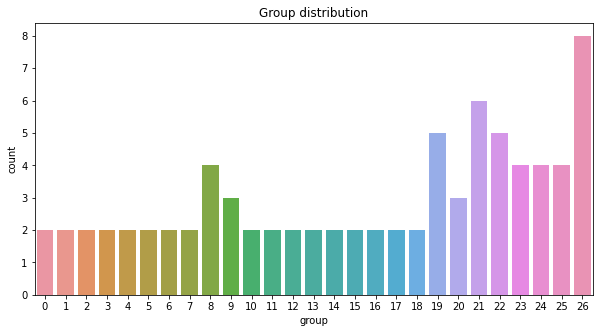

In [ ]:
mexico_08 = pd.read_csv("Mexico_similarities_08.csv")
data_attributes(mexico_08)

Number of groups in the data: 24


Number of rows in the data: 125


row count in each group:

group
0      2
1      2
2      2
3      2
4      2
5      2
6      4
7      3
8      2
9      2
10     2
11     4
12     5
13     3
14     3
15     3
16     4
17     3
18     8
19     2
20     4
21     5
22    45
23    11
Name: name, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


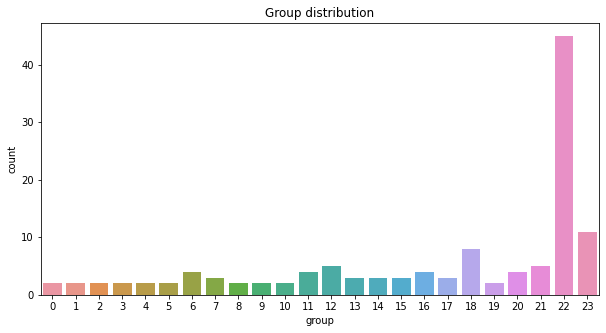

In [ ]:
mexico_075 = pd.read_csv("Mexico_similarities_075.csv")
data_attributes(mexico_075)

Number of groups in the data: 32


Number of rows in the data: 185


row count in each group:

group
0      2
1      2
2      2
3      2
4      2
5      4
6      3
7      2
8      2
9      2
10     2
11     5
12     2
13     3
14     3
15     3
16     3
17     4
18     3
19     3
20     3
21     6
22     3
23     2
24     2
25     3
26     3
27     2
28     3
29    15
30    74
31    15
Name: name, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


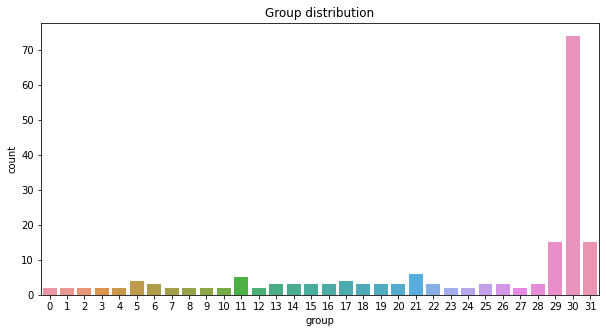

In [ ]:
mexico_07 = pd.read_csv("Mexico_similarities_07.csv")
data_attributes(mexico_07)

Group 30 contains many rows (74). Probably the group isn't homogenic and it's better to divide the group the number of groups. 

In [ ]:
mexico_07[mexico_07["group"] == 30]

,Unnamed: 0,group,name,address,location_point,about,tags,prediction,price,duration,source,external_id,about_avg_score,name_avg_score,final_avg_score
96,42,30,Enjoy the Best Bars in Mexico City,"2a. Cerrada de Olivo, 2a. Cda. de Olivo, Flori...",NaN,"During our nightlife adventure, I will take yo...","('Guided Tours, Culture, Hidden Gems',)","['Culinary Experiences', 'Guided Tours']",36.00,109800,TripAdvisor,NaN,0.752394,0.589542,0.447312
97,7,30,Mexico City Private Day Tour,"Calle Dr Mora 9, Colonia Centro, Centro, Cuauh...",NaN,"On this Mexico City Day tour, we'll trace the ...","('Walking & Biking, Guided Tours, Hidden Gems,...","['Architecture', 'Culture', 'Guided Tours', 'H...",27.00,7200,TripAdvisor,NaN,0.752394,0.589542,0.447312
98,46,30,Guided Walking Tour to the Archaeological Zone...,Zona Arqueológica de Teotihuacan Estacionamien...,NaN,"The cheapest tour of Teotihuacan, you can be p...","('Guided Tours, Historic Sites, Walking & Biki...","['Culture', 'Guided Tours', 'Historic Sites', ...",30.00,10800,TripAdvisor,NaN,0.752394,0.589542,0.447312
99,48,30,Mexico City's Historical Center Icons,"P.za de la Constitución 803, Centro Histórico ...",NaN,We will take a walk around Mexico City's Histo...,"('Guided Tours, Walking & Biking, Historic Sit...","['Culture', 'Museums']",35.00,14400,TripAdvisor,NaN,0.752394,0.589542,0.447312
100,50,30,Flavors of Mexico - Mexican Food Experiencie,"Balderas 95, Colonia Centro, Centro, Cuauhtémo...",NaN,Enjoy Mexico through his flavours and rich gas...,"('Guided Tours, Walking & Biking, Street Food',)",['Culinary Experiences'],39.99,10800,TripAdvisor,NaN,0.752394,0.589542,0.447312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,87,30,The Beauty of Coyoacan by Bike Private Tour wi...,"Calle Presidente Carranza, Calle Pdte. Carranz...",NaN,Coyoacan is a village within the city. With hi...,"('Guided Tours, Walking & Biking, Historic Sit...","['Guided Tours', 'Nature', 'Outdoor Activities...",42.36,10800,TripAdvisor,NaN,0.752394,0.589542,0.447312
166,92,30,Private Walking Tour of Mexico City Highlights,"Angela Peralta, Colonia Centro, Centro, 06050 ...",NaN,Get ready to experience Mexico City the local ...,"('Guided Tours, Walking & Biking, Historic Sit...","['Culture', 'Guided Tours', 'Popular', 'Walkin...",55.30,109800,TripAdvisor,NaN,0.752394,0.589542,0.447312
167,1,30,TEOTIHUACAN with a certified local guide,"Teotihuacán, Pirámide del Sol, 55829 Méx., Mexico",NaN,Avoid the crowds on this early morning tour of...,"('Guided Tours, Historic Sites, Walking & Biki...","['Architecture', 'Guided Tours', 'Historic Sit...",40.00,14400,TripAdvisor,NaN,0.752394,0.589542,0.447312
168,89,30,Half Day Bicycle Tour in Mexico City,"Av. Paseo de la Reforma 18, Juárez, Cuauhtémoc...",NaN,On this tour I will take you to the most Mexic...,"('Guided Tours, Walking & Biking, Culture, Loc...","['Nature', 'Outdoor Activities', 'Popular', 'W...",34.92,21600,TripAdvisor,NaN,0.752394,0.589542,0.447312


Basically, maybe we can divide this group to two groups: one group is connected to guided tour and the second group is connected to culinary experience

In [ ]:
mexico_075[mexico_075["group"] == 22]

,Unnamed: 0,group,name,address,location_point,about,tags,prediction,price,duration,source,external_id,about_avg_score,name_avg_score,address_avg_score,final_avg_score
69,80,22,"Narvarte At Night: Tacos, Chelas & Mezcal","Cumbres de Maltrata 352, Narvarte Oriente, Ben...",NaN,Narvarte is known throughout Mexico City for i...,"('Guided Tours, Walking & Biking',)",['Culinary Experiences'],109.71,109800,TripAdvisor,NaN,0.783022,0.612823,0.654883,0.465282
70,78,22,The 10 Tastings of Mexico With Locals: Private...,"Av Francisco I. Madero 1, Centro Histórico de ...",NaN,Eat your way through Mexico City's culinary sc...,"('Guided Tours, Walking & Biking, Cuisine',)","['Culinary Experiences', 'Guided Tours']",56.48,10800,TripAdvisor,NaN,0.783022,0.612823,0.654883,0.465282
71,77,22,Mexico City Night Food Bike Tour,"Amsterdam 275, Hipódromo, Cuauhtémoc, 06100 Ci...",NaN,Exploring Mexico City by bike is great because...,"('Guided Tours, Walking & Biking, Street Food,...","['Culinary Experiences', 'Nature', 'Outdoor Ac...",54.88,14400,TripAdvisor,NaN,0.783022,0.612823,0.654883,0.465282
72,48,22,Mexico City's Historical Center Icons,"P.za de la Constitución 803, Centro Histórico ...",NaN,We will take a walk around Mexico City's Histo...,"('Guided Tours, Walking & Biking, Historic Sit...","['Culture', 'Museums']",35.00,14400,TripAdvisor,NaN,0.783022,0.612823,0.654883,0.465282
73,71,22,The best of Mexico CDMX walking tour,"Londres 247, Del Carmen, Coyoacán, 04100 Ciuda...",NaN,"Together with the professional guide, you will...","('Guided Tours, Walking & Biking, Historic Sit...","['Culture', 'Guided Tours', 'Popular', 'Walkin...",461.70,7200,TripAdvisor,NaN,0.783022,0.612823,0.654883,0.465282
74,57,22,The best of Mixquic walking tour,"Parroquia de San Andrés Apóstol, Plaza Juárez,...",NaN,"Together with the professional guide, you will...","('Guided Tours, Walking & Biking, Historic Sit...","['Culture', 'Guided Tours', 'Popular', 'Walkin...",461.70,7200,TripAdvisor,NaN,0.783022,0.612823,0.654883,0.465282
75,54,22,Mexican muralism,"Metropolitan Church Mexico City, P.za de la Co...",NaN,Discover the Mexican History through its walls...,"('Walking & Biking, Guided Tours, Art, Histori...","['Culture', 'Guided Tours', 'Historic Sites', ...",25.99,109800,TripAdvisor,NaN,0.783022,0.612823,0.654883,0.465282
76,51,22,Most Authentic Mexico City's Street Food!,"Museo Nacional De Arte (MUNAL), Calle de Tacub...",NaN,Would you like to try the exquisite street foo...,"('Guided Tours, Walking & Biking, Street Food',)",['Culinary Experiences'],32.00,18000,TripAdvisor,NaN,0.783022,0.612823,0.654883,0.465282
77,50,22,Flavors of Mexico - Mexican Food Experiencie,"Balderas 95, Colonia Centro, Centro, Cuauhtémo...",NaN,Enjoy Mexico through his flavours and rich gas...,"('Guided Tours, Walking & Biking, Street Food',)",['Culinary Experiences'],39.99,10800,TripAdvisor,NaN,0.783022,0.612823,0.654883,0.465282
78,85,22,Private City Kickstart Tour: Mexico City,"Angela Peralta, Colonia Centro, Centro, 06050 ...",NaN,Receive a warm welcome to Mexico City on a pri...,"('Guided Tours, Walking & Biking, Historic Sit...",['Guided Tours'],20.00,109800,TripAdvisor,NaN,0.783022,0.612823,0.654883,0.465282


Group 22 in mexico_075 data can be divided to 4 groups: "culinary tour", "Histoirc tour", "art", "bike tour"

What are the indices that obtained in 0.75 and are missing in 0.8 data? is it FP or FN?

In [ ]:
added_idx_075 = set(mexico_075[mexico_075.columns[0]].values) - set(mexico_08[mexico_08.columns[0]].values)
added_idx_075

{1,
 6,
 9,
 10,
 23,
 25,
 26,
 35,
 41,
 46,
 48,
 50,
 69,
 73,
 77,
 78,
 80,
 87,
 94,
 107,
 109,
 112,
 113,
 116,
 124,
 125,
 126,
 127,
 138,
 140,
 145,
 147,
 152,
 154,
 160,
 162,
 166,
 173,
 184,
 189,
 259,
 305,
 311,
 313,
 323}

1, 46: should be in the similarity data. These rows are a part of group 20 in  0.75 and are supposed to be a part of group 4 in 0.8 data

9, 23, 69: all indices of a group in 0.75 (all connected to Colonia Roma Legacy) and are missing from 0.8 - FN in 0.8. 

323: Belong to group 23 in 0.8- FN

Group 22 in 0.75 is too large and can be divided to several groups. One of the groups is connected to "street food". Actually, some of these indices were accepted at 0.8 as a speparate group, but still many of the indices are still missing - FN:
<br>
35, 50, 78, 124, 125, 126

0.7 data: the groups are too heterogeneous...

at 0.75 group 23 seems like TP, however lots of indices from this group are not in the data of o.8. Only 3 of the indices are at 0.8: 153, 155, 170.
<br>
FN: 152, 154, 160, 162, 166, 173
<br>
156, 159 are separated to different group at 0.8 data

From the above results I decided to run the code on 0.78 threshold (0.75-0.8). It seems to have achieved the best results: homogeneious groups with lower FN than 0.8

Threshold = 0.78:

Number of groups in the data: 27


Number of rows in the data: 105


row count in each group:

group
0      2
1      2
2      2
3      2
4      2
5      2
6      2
7      4
8      3
9      2
10     2
11     2
12     2
13     2
14     4
15     2
16     2
17     5
18     2
19     7
20     3
21     2
22     5
23     2
24    25
25     5
26    10
Name: name, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


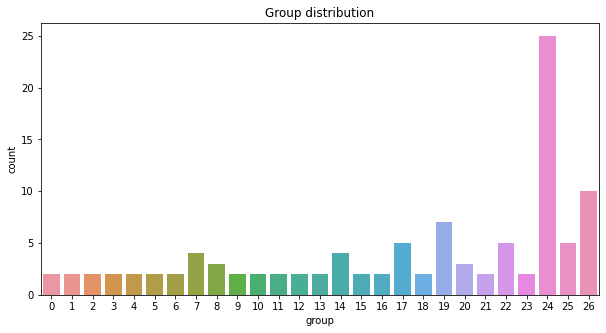

In [ ]:
mexico_078 = pd.read_csv("Mexico_similarities_078.csv")
data_attributes(mexico_078)

In [ ]:
mexico_078

,Unnamed: 0,group,name,address,location_point,about,tags,prediction,price,duration,source,external_id,about_avg_score,name_avg_score,address_avg_score,final_avg_score
0,256,0,Wingstop Alameda Patio Juárez,"Avenida Juárez 3, Eje Central Lázaro Cárdenas ...","('SRID=4326;POINT (-99.1435151 19.4343853)',)",Counter-serve chicken wing chain. Casual count...,Beach,['Street Food'],NaN,NaN,GoogleMaps,NaN,1.000000,0.622677,0.602134,0.540892
1,242,0,Wingstop Buenavista,"Av. Insurgentes Nte. 188, Sta María la Ribera,...","('SRID=4326;POINT (-99.1535487 19.446095)',)",Counter-serve chicken wing chain. Casual count...,Beach,['Street Food'],NaN,NaN,GoogleMaps,NaN,1.000000,0.622677,0.602134,0.540892
2,183,1,Office Depot Portal Centro Boturini,"LOCAL JA-02, Lorenzo Boturini 258, Tránsito, C...","('SRID=4326;POINT (-99.1296318 19.4193797)',)",Standby for office & school supplies. Chain se...,Shopping,['Shopping'],NaN,NaN,GoogleMaps,NaN,1.000000,0.610432,0.756662,0.536811
3,175,1,Office Depot Express,"Rio Panuco 127, Cuauhtémoc, 06500 Ciudad de Mé...",('SRID=4326;POINT (-99.16935509999999 19.42992...,Standby for office & school supplies. Chain se...,Shopping,['Shopping'],NaN,NaN,GoogleMaps,NaN,1.000000,0.610432,0.756662,0.536811
4,191,2,Sephora,"Perif. Blvd. Manuel Ávila Camacho 5-Local 158,...",('SRID=4326;POINT (-99.22643939999999 19.46842...,Retailer known for makeup & perfumes. Retail c...,Shopping,['Shopping'],NaN,NaN,GoogleMaps,NaN,1.000000,0.831774,0.429709,0.610591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,80,26,"Narvarte At Night: Tacos, Chelas & Mezcal","Cumbres de Maltrata 352, Narvarte Oriente, Ben...",NaN,Narvarte is known throughout Mexico City for i...,"('Guided Tours, Walking & Biking',)",['Culinary Experiences'],109.71,109800,TripAdvisor,NaN,0.794809,0.618018,0.604968,0.470943
101,50,26,Flavors of Mexico - Mexican Food Experiencie,"Balderas 95, Colonia Centro, Centro, Cuauhtémo...",NaN,Enjoy Mexico through his flavours and rich gas...,"('Guided Tours, Walking & Biking, Street Food',)",['Culinary Experiences'],39.99,10800,TripAdvisor,NaN,0.794809,0.618018,0.604968,0.470943
102,51,26,Most Authentic Mexico City's Street Food!,"Museo Nacional De Arte (MUNAL), Calle de Tacub...",NaN,Would you like to try the exquisite street foo...,"('Guided Tours, Walking & Biking, Street Food',)",['Culinary Experiences'],32.00,18000,TripAdvisor,NaN,0.794809,0.618018,0.604968,0.470943
103,88,26,Tacos and Mezcal Crawl in Roma Norte,"Av. Álvaro Obregón 39, Roma Nte., Cuauhtémoc, ...",NaN,"This is, hands down, the best food & drink exp...","('Guided Tours, Walking & Biking, Street Food',)",['Culinary Experiences'],65.00,10800,TripAdvisor,NaN,0.794809,0.618018,0.604968,0.470943


In [ ]:
duplicates_078 = pd.read_csv("Mexico_duplicates_078.csv")
data_attributes(duplicates_078)

Number of groups in the data: 10


Number of rows in the data: 20


row count in each group:

group
0     2
1     2
2     2
3     2
4     2
5     2
6     2
12    2
17    2
22    2
Name: name, dtype: int64


In [ ]:
def threshold_df(df_list, threshold_list, all_data_reduced_length):
  threshold_comparison_df = pd.DataFrame(columns=["threshold", "num_groups", "num_rows", "percentage"])
  num_groups = [df["group"].nunique() for df in df_list]
  num_rows = [df.shape[0] for df in df_list]
  percentage = [df.shape[0]/all_data_reduced_length*100 for df in df_list]
  threshold_comparison_df["threshold"] = threshold_list
  threshold_comparison_df["num_groups"] = num_groups
  threshold_comparison_df["num_rows"] = num_rows
  threshold_comparison_df["percentage"] = percentage
  return threshold_comparison_df

def plot_similar_data_percentage(threshold_df): 
  fig = plt.figure(figsize=(10,7))
  plt.plot("threshold", "percentage", 'bo-', data=threshold_df)
  plt.xlabel("Threshold")
  plt.ylabel("% Similar data")
  plt.ylim((0,70))
  plt.title("%similar data vs Threshold")
  plt.show()

In [ ]:
all_mexico = pd.read_csv("all_mexico_tagged.csv")
all_mexico.drop_duplicates(subset=['name', 'about'], inplace=True)
all_mexico.dropna(subset=['name', 'about'], inplace=True)
all_mexico.shape

(469, 22)

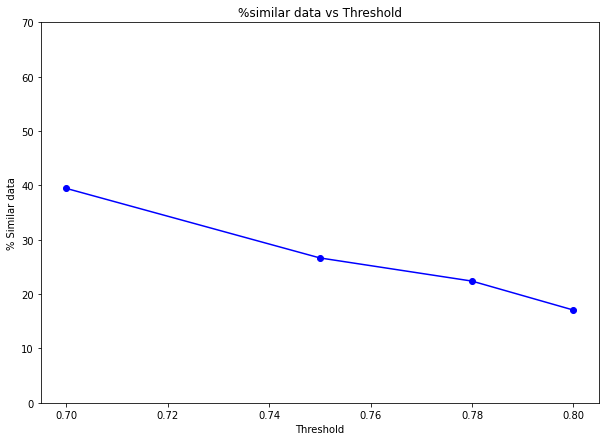

In [ ]:
mexico_threshold_results = [mexico_07, mexico_075, mexico_078, mexico_08]
thresholds_list = [0.7, 0.75, 0.78, 0.8]
mexico_threshold_df = threshold_df(mexico_threshold_results, thresholds_list, all_mexico.shape[0])

plot_similar_data_percentage(mexico_threshold_df)

In [ ]:
mexico_threshold_df

,threshold,num_groups,num_rows,percentage
0,0.70,32,185,39.445629
1,0.75,24,125,26.652452
2,0.78,27,105,22.388060
3,0.80,27,80,17.057569


####LONDON  (Shape after removing duplicates: (606, 44))

In [ ]:
london_06 = pd.read_csv("London_similarities_06.csv")
london_07 = pd.read_csv("London_similarities_07.csv")
london_075 = pd.read_csv("London_similarities_075.csv")
london_078 = pd.read_csv("London_similarities_078.csv")
london_08 = pd.read_csv("London_similarities_08.csv")

Number of groups in the data: 19


Number of rows in the data: 42


row count in each group:

group
0     2
1     2
2     2
3     2
4     2
5     3
6     2
7     2
8     2
9     2
10    2
11    2
12    3
13    2
14    2
15    4
16    2
17    2
18    2
Name: name, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


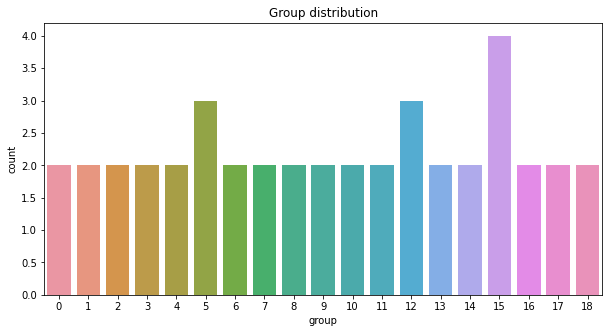

In [ ]:
data_attributes(london_08)

Number of groups in the data: 30


Number of rows in the data: 68


row count in each group:

group
0     2
1     2
2     2
3     2
4     2
5     3
6     2
7     2
8     2
9     2
10    2
11    2
12    2
13    2
14    2
15    2
16    3
17    2
18    2
19    2
20    2
21    3
22    6
23    2
24    2
25    2
26    2
27    2
28    2
29    3
Name: name, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


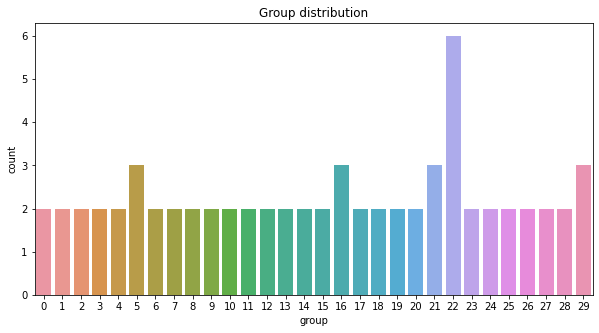

In [ ]:
data_attributes(london_078)

Number of groups in the data: 43


Number of rows in the data: 116


row count in each group:

group
0     2
1     2
2     2
3     2
4     2
5     3
6     2
7     2
8     2
9     2
10    2
11    2
12    2
13    2
14    2
15    2
16    2
17    2
18    2
19    2
20    2
21    2
22    2
23    2
24    3
25    3
26    4
27    2
28    4
29    8
30    2
31    2
32    3
33    3
34    3
35    2
36    2
37    3
38    5
39    8
40    4
41    2
42    4
Name: name, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


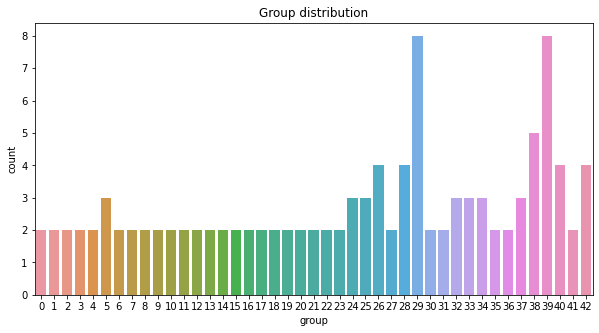

In [ ]:
data_attributes(london_075)

Number of groups in the data: 49


Number of rows in the data: 191


row count in each group:

group
0      2
1      2
2      2
3      2
4      2
5      3
6      2
7      2
8      2
9      2
10     2
11     2
12     2
13     2
14     2
15     2
16     2
17     3
18     2
19     2
20     3
21     2
22     2
23     2
24     4
25     2
26     3
27     2
28     2
29     2
30     2
31     2
32     3
33     6
34     5
35     3
36     4
37     2
38     3
39     7
40     2
41    23
42     4
43     8
44     4
45     5
46    13
47     4
48    25
Name: name, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


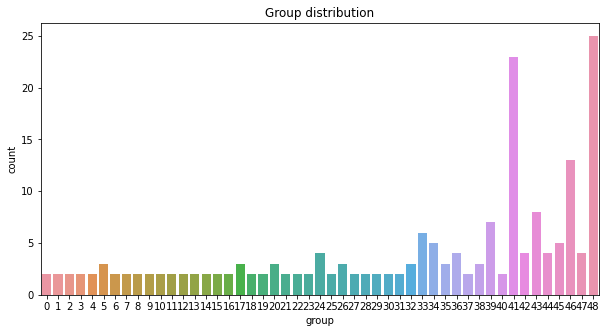

In [ ]:
data_attributes(london_07)

In [ ]:
all_london = pd.read_csv("all_london_tagged.csv")
all_london.drop_duplicates(subset=['name', 'about'], inplace=True)
all_london.dropna(subset=['name', 'about'], inplace=True)

In [ ]:
london_threshold_results = [london_06, london_07, london_075, london_078, london_08]
thresholds_list = [0.6, 0.7, 0.75, 0.78, 0.8]

london_threshold_df = threshold_df(london_threshold_results, thresholds_list, all_london.shape[0])

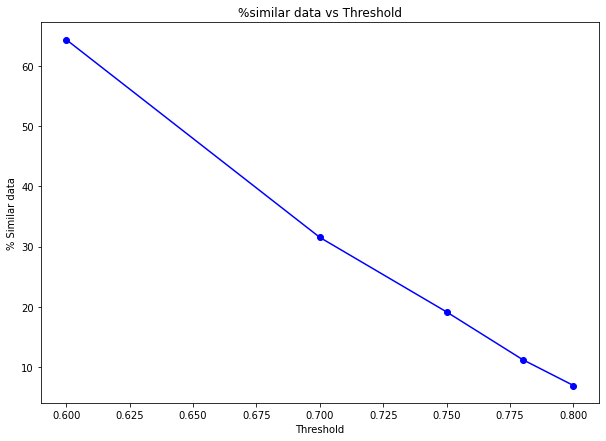

In [ ]:
def plot_similar_data_percentage(threshold_df): 
  fig = plt.figure(figsize=(10,7))
  plt.plot("threshold", "percentage", 'bo-', data=threshold_df)
  plt.xlabel("Threshold")
  plt.ylabel("% Similar data")
  plt.title("%similar data vs Threshold")
  plt.show()

plot_similar_data_percentage(london_threshold_df)

checking the difference between the groups of the different thresholds

In [ ]:
# which lines are at 0.75 threshold but not at 0.78 threshold? are they FN at 0.78 threshold or FP at 0.75?
set(london_075["Unnamed: 0"]) - set(london_078["Unnamed: 0"])

{0,
 1,
 2,
 4,
 20,
 25,
 32,
 42,
 71,
 84,
 88,
 89,
 115,
 227,
 243,
 246,
 301,
 342,
 348,
 361,
 363,
 365,
 368,
 372,
 392,
 396,
 398,
 423,
 431,
 448,
 450,
 451,
 464,
 467,
 470,
 487,
 491,
 494,
 508,
 521,
 529,
 530,
 551,
 562,
 564,
 581,
 591,
 599}

0, 1,4: art shop. FN at 0.78
<br>
2: can be FP or FN. a bit different than the other rows in the group
